<a href="https://colab.research.google.com/github/EisaacJC/Deep-Learning-4-CV/blob/main/Hw3_DL4CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.1881 - loss: 2.6379 - val_accuracy: 0.2488 - val_loss: 2.4364
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2842 - loss: 2.3430 - val_accuracy: 0.3036 - val_loss: 2.2942
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3113 - loss: 2.2516 - val_accuracy: 0.3036 - val_loss: 2.2844
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3308 - loss: 2.1879 - val_accuracy: 0.3172 - val_loss: 2.2304
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3498 - loss: 2.1200 - val_accuracy: 0.3274 - val_loss: 2.1953
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3658 - loss: 2.0634 - val_accuracy: 0.3246 - val_loss: 2.2097
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3752 - loss: 2.0250 - val_accuracy: 0.3334 - val_loss: 2.1923
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

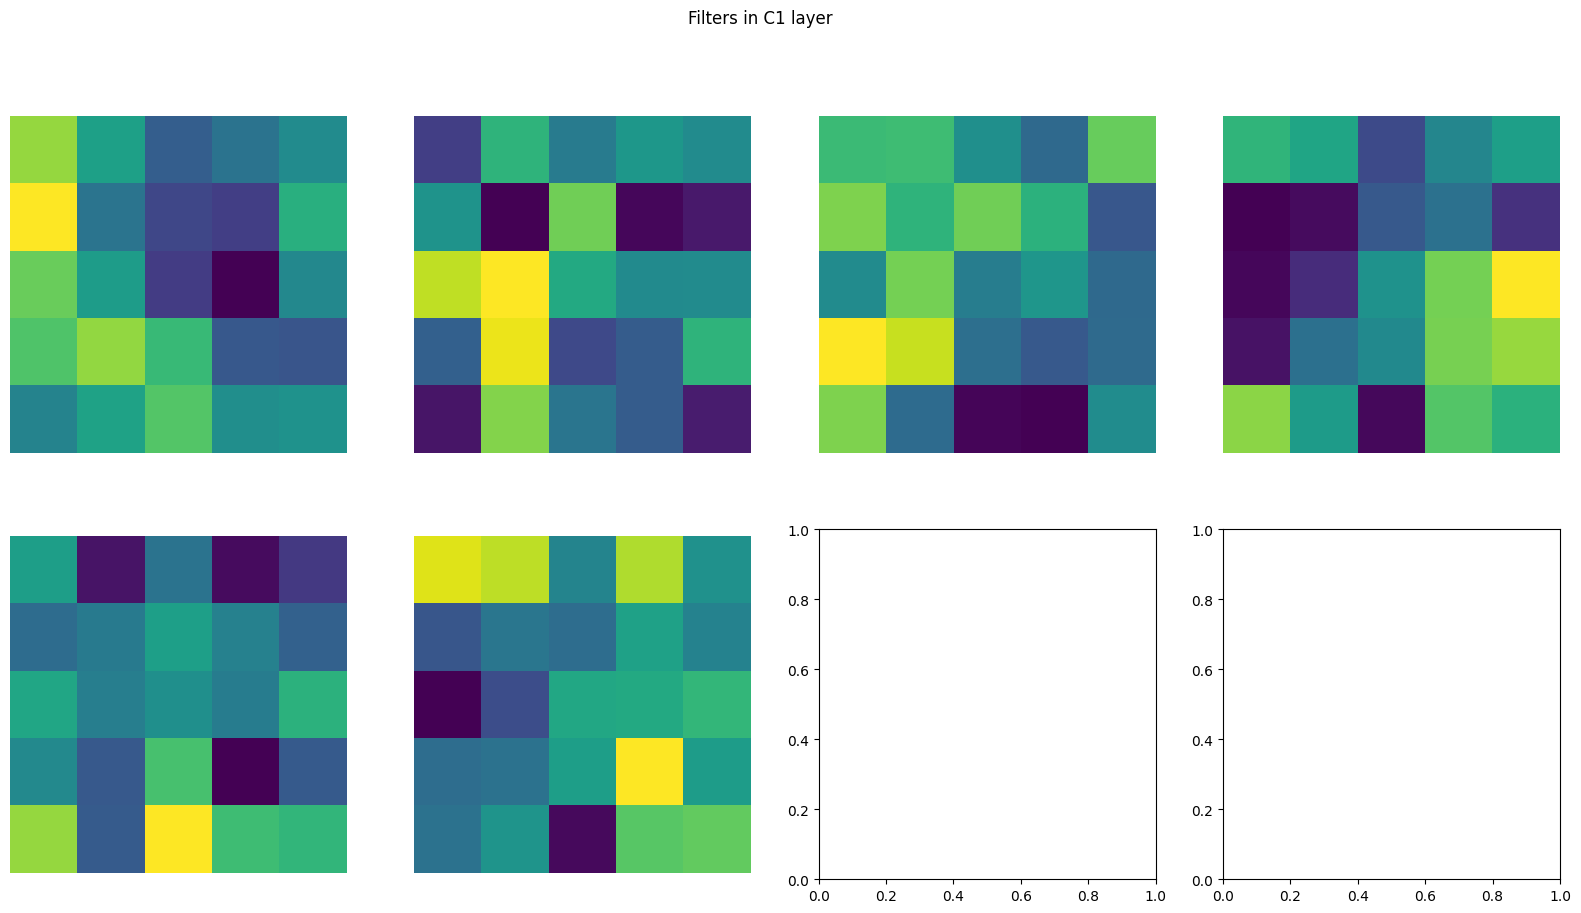

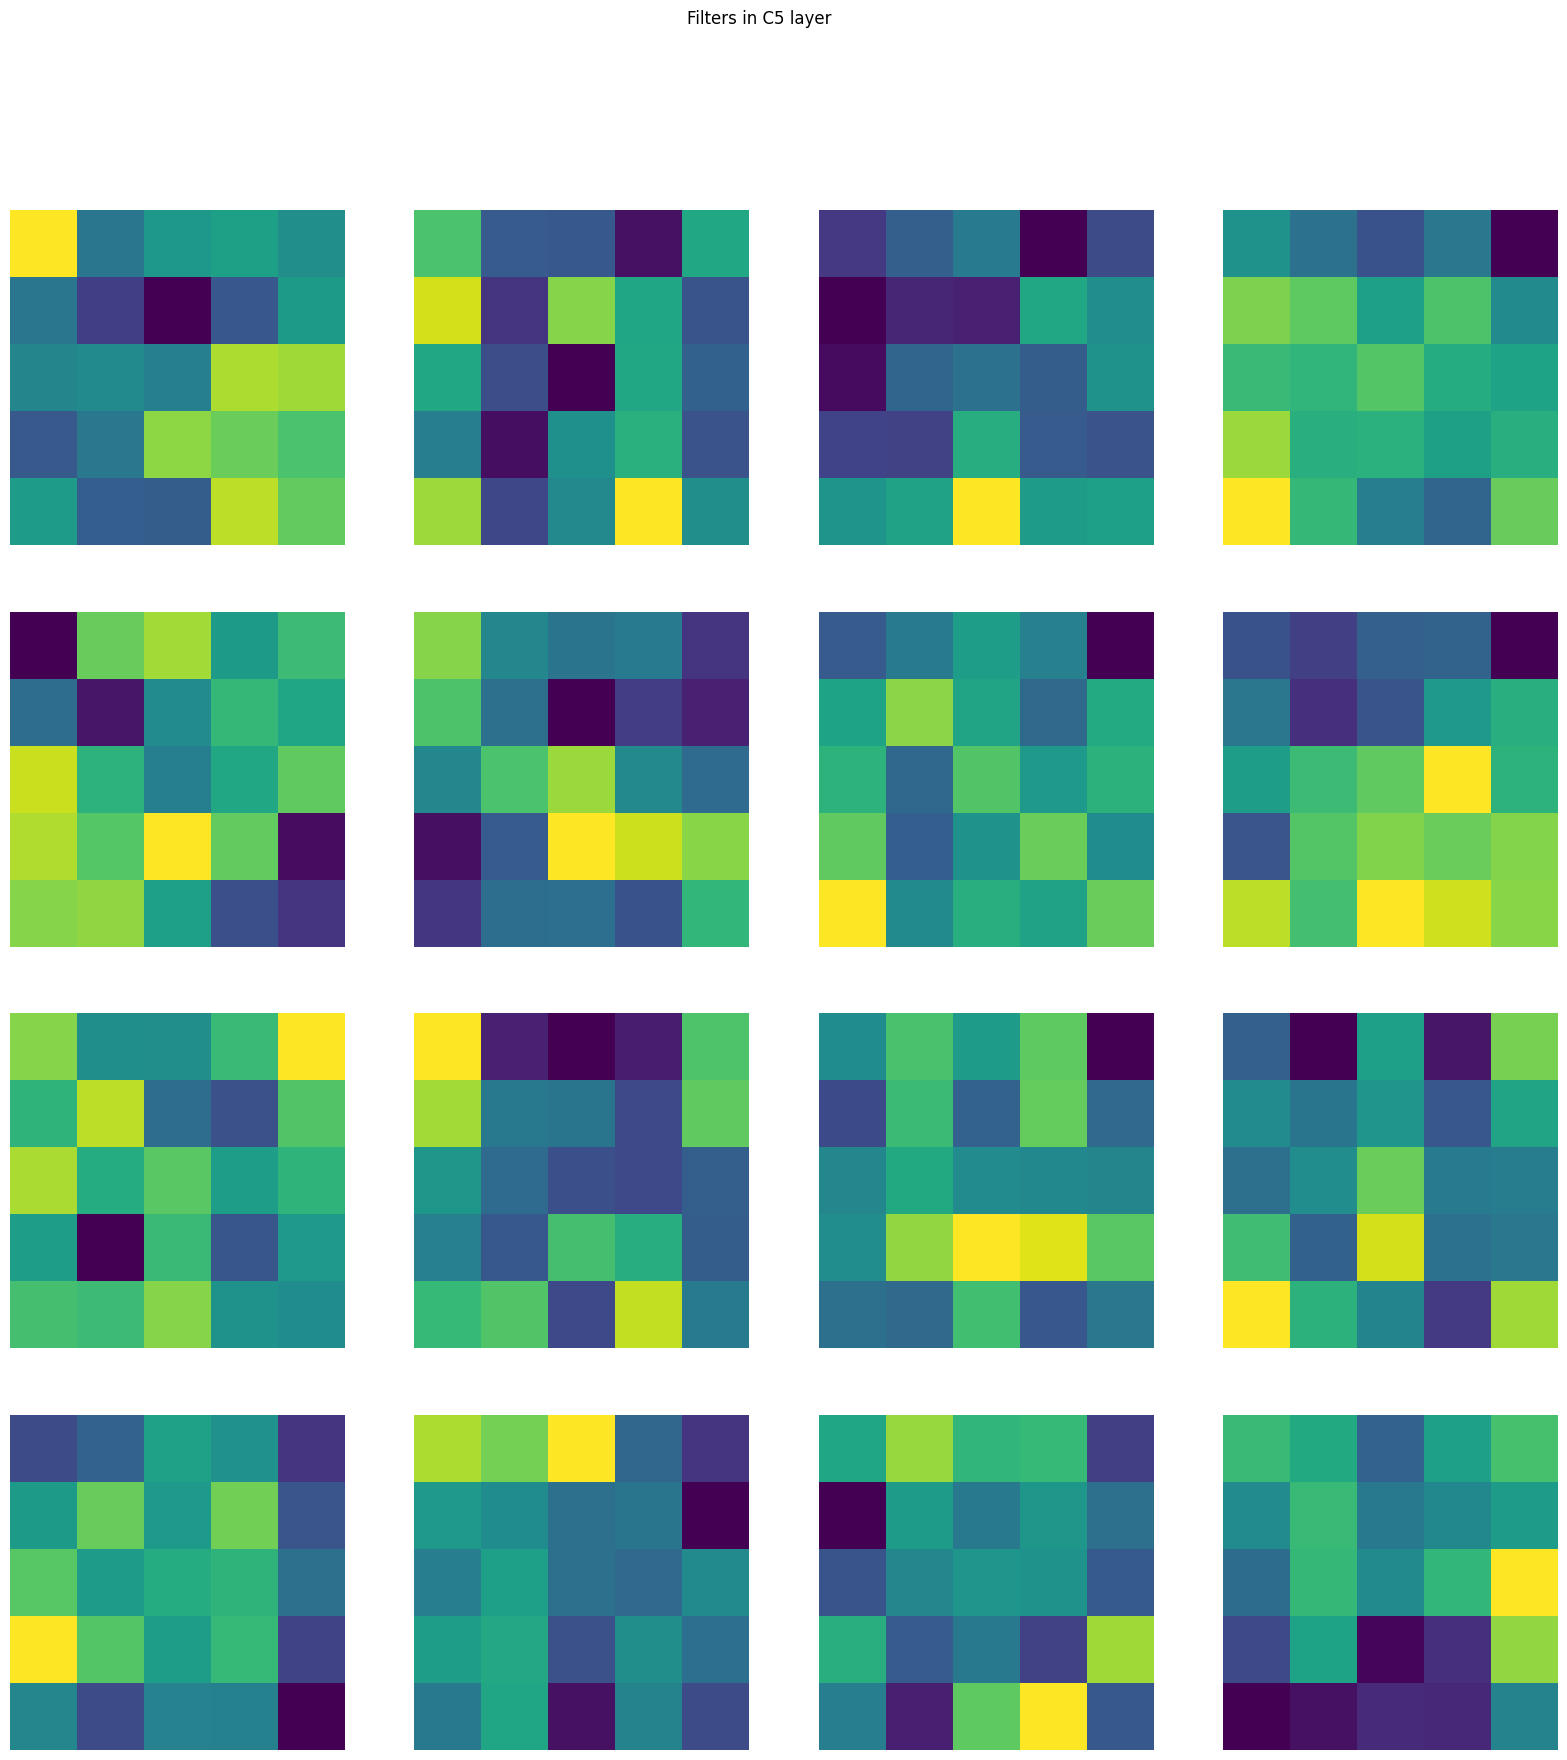


Generating feature space visualization...

Generating saliency maps for sample images...


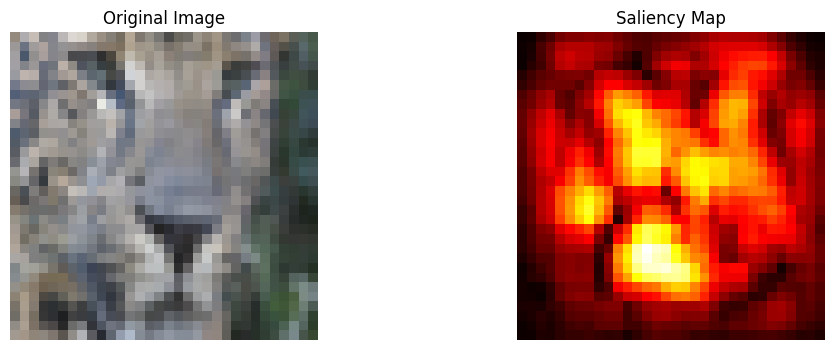

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE
import seaborn as sns

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
y_train = to_categorical(y_train, 20)
y_test = to_categorical(y_test, 20)

def lenet_cifar():
    inputs = Input(shape=(32, 32, 3))
    x = Conv2D(6, kernel_size=5, activation="tanh", padding="same", name="C1")(inputs)
    x = AveragePooling2D(pool_size=(2, 2), strides=2, name="S2")(x)
    x = Conv2D(16, kernel_size=5, activation="tanh", name="C3")(x)
    x = AveragePooling2D(pool_size=(2, 2), strides=2, name="S4")(x)
    x = Conv2D(120, kernel_size=5, activation="tanh", name="C5")(x)
    x = Flatten()(x)
    x = Dense(84, activation="tanh", name="F6")(x)
    outputs = Dense(20, activation="softmax", name="output")(x)
    return Model(inputs=inputs, outputs=outputs)

def visualize_filters(model, layer_name, n_filters=None):
    layer = model.get_layer(layer_name)
    filters, _ = layer.get_weights()

    if n_filters is None:
        n_filters = filters.shape[3]

    n_rows = n_filters // 4 + (1 if n_filters % 4 != 0 else 0)
    fig, axs = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))

    for i in range(min(n_filters, filters.shape[3])):
        ax = axs[i//4, i%4] if n_rows > 1 else axs[i%4]
        if layer_name == "C1":
            filter_img = np.mean(filters[:, :, :, i], axis=2)
        else:
            filter_img = filters[:, :, 0, i]
        ax.imshow(filter_img, cmap='viridis')
        ax.axis('off')

    plt.suptitle(f'Filters in {layer_name} layer')
    plt.show()

def feature_space_visualization(model, x_data, y_data, layer_name='F6'):
    layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = layer_model.predict(x_data)
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=np.argmax(y_data, axis=1),
                         cmap='tab20', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f'Feature Space Visualization ({layer_name} layer)')
    plt.show()

def compute_saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image[np.newaxis, ...])

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor)
        loss = predictions[:, class_idx]

    gradients = tape.gradient(loss, image_tensor)
    saliency_map = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_map[0].numpy()

def visualize_saliency(model, image, true_class):
    saliency = compute_saliency_map(model, image, true_class)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(saliency, cmap='hot')
    ax2.set_title('Saliency Map')
    ax2.axis('off')
    plt.show()
def train_and_analyze_model():
    model = lenet_cifar()
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
    print("Visualizing filters from first (C1) and last (C5) convolutional layers...")
    visualize_filters(model, "C1")
    visualize_filters(model, "C5", n_filters=16)
    print("\nGenerating feature space visualization...")
    #feature_space_visualization(model, x_test[:1000], y_test[:1000])

    print("\nGenerating saliency maps for sample images...")
    img_idx = np.random.randint(0, len(x_test))
    true_class = np.argmax(y_test[img_idx])
    visualize_saliency(model, x_test[img_idx], true_class)

    return model, history

if __name__ == "__main__":
    model, history = train_and_analyze_model()

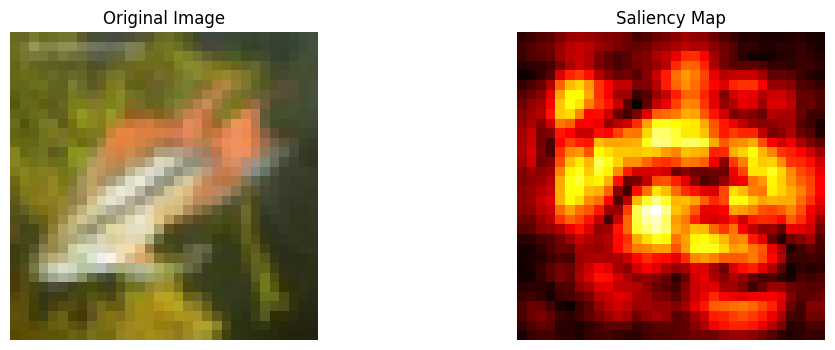

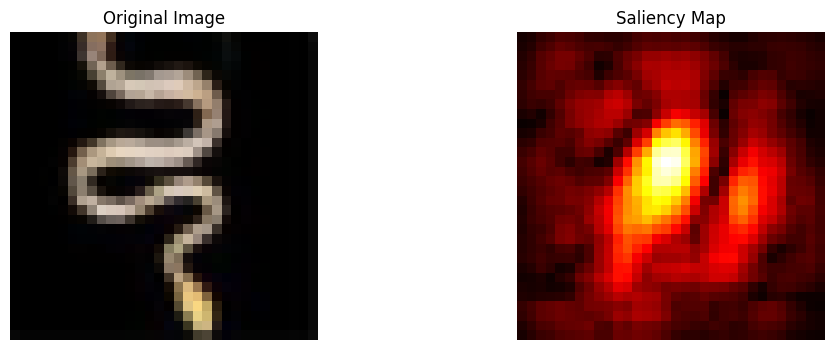

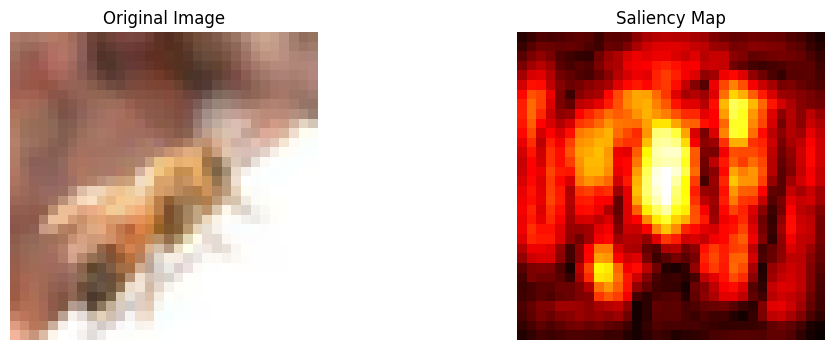

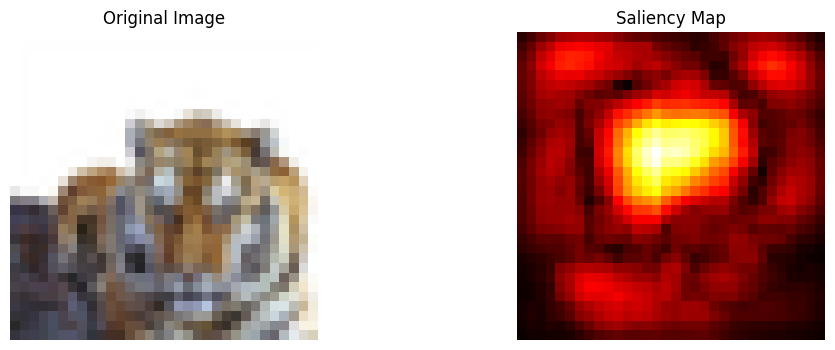

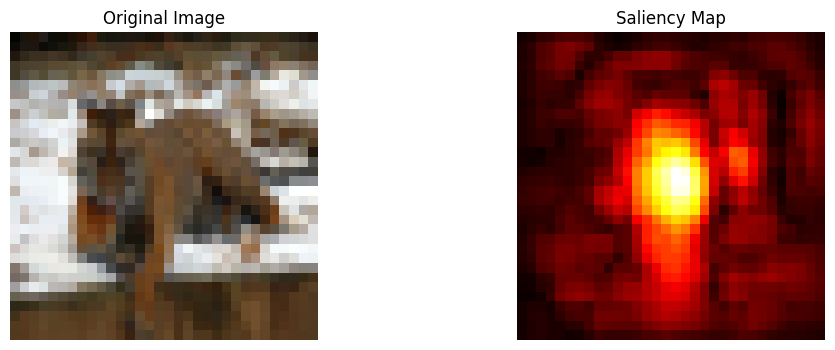

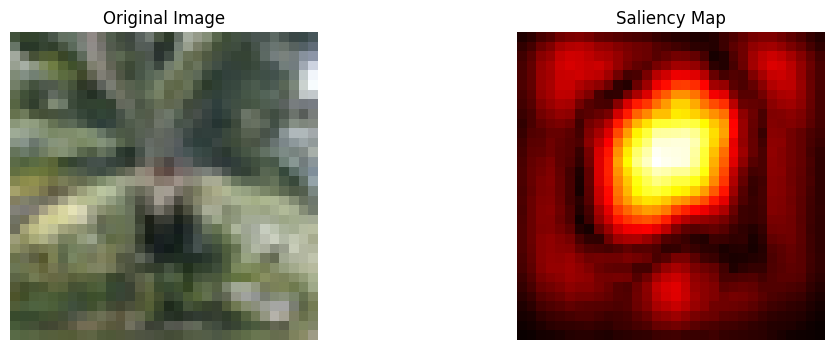

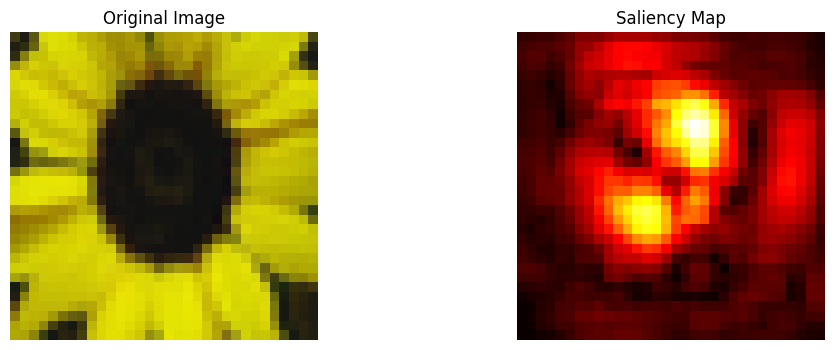

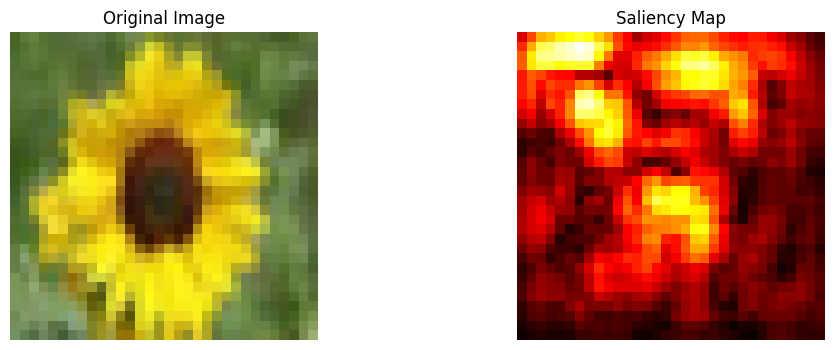

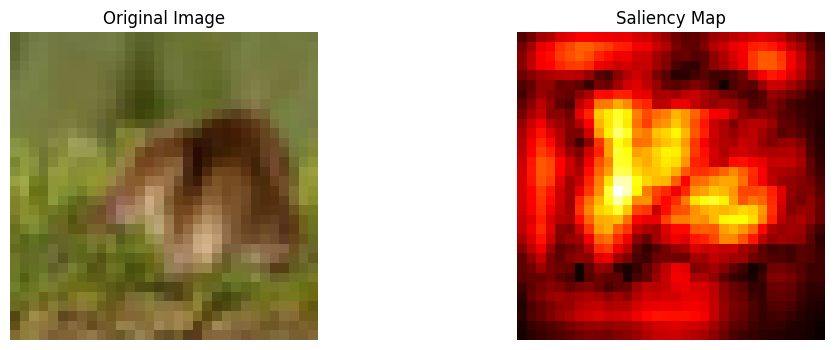

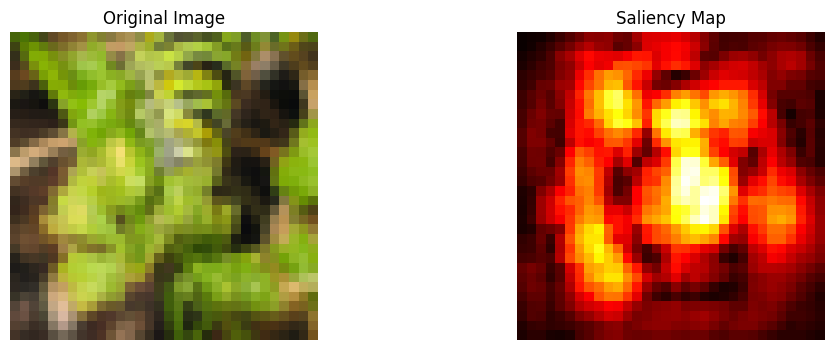

In [2]:
for i in range(10):
    img_idx = np.random.randint(0, len(x_test))
    true_class = np.argmax(y_test[img_idx])
    visualize_saliency(model, x_test[img_idx], true_class)

In [3]:
import tensorflow as tf
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs available: {len(gpus)}")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available")
tf.keras.mixed_precision.set_global_policy('mixed_float16')

Physical devices cannot be modified after being initialized


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size=32, target_size=(96, 96)):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = tf.convert_to_tensor([
            tf.image.resize(self.x[i], self.target_size)
            for i in batch_indices
        ])
        batch_x = tf.cast(batch_x, tf.float32)
        batch_x = tf.keras.applications.efficientnet.preprocess_input(batch_x)
        batch_y = self.y[batch_indices]
        return batch_x, batch_y

def load_dataset(dataset_name, batch_size=32, target_size=(96, 96)):
    if dataset_name == 'cifar10':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
        num_classes = 10
    elif dataset_name == 'cifar100':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
        num_classes = 100
    elif dataset_name == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)
        x_train, x_test = np.repeat(x_train, 3, axis=-1), np.repeat(x_test, 3, axis=-1)
        num_classes = 10
    elif dataset_name == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)
        x_train, x_test = np.repeat(x_train, 3, axis=-1), np.repeat(x_test, 3, axis=-1)
        num_classes = 10

    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    train_generator = DataGenerator(x_train, y_train, batch_size=batch_size, target_size=target_size)
    test_generator = DataGenerator(x_test, y_test, batch_size=batch_size, target_size=target_size)

    return train_generator, test_generator, num_classes

def create_efficient_model(input_shape=(96, 96, 3), num_classes=10):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers[:100]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    features = GlobalAveragePooling2D(name='features')(x)
    x = Dropout(0.5)(features)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision_metric'),
            tf.keras.metrics.Recall(name='recall_metric')
        ]
    )
    return model

def plot_training_history(history):
    metrics = {'accuracy': 'Accuracy', 'loss': 'Loss'}
    if 'precision_metric' in history.history:
        metrics['precision_metric'] = 'Precision'
    if 'recall_metric' in history.history:
        metrics['recall_metric'] = 'Recall'
    n_metrics = len(metrics)
    n_rows = (n_metrics + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    fig.suptitle('Training Metrics')
    if n_rows > 1:
        axes = axes.flatten()
    for idx, (metric, title) in enumerate(metrics.items()):
        ax = axes[idx] if n_rows > 1 else axes[idx % 2]
        ax.plot(history.history[metric], label='Training')
        if f'val_{metric}' in history.history:
            ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(f'Model {title}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True)
    if n_rows > 1:
        for idx in range(len(metrics), len(axes)):
            fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()
def visualize_conv_layers(model, image):
    # Get base model
    base_model = model.layers[1]
    conv_names = ['block1a_project_conv', 'block4a_project_conv', 'block7a_project_conv']

    for layer_name in conv_names:
        try:
            layer = base_model.get_layer(layer_name)
            temp_model = Model(inputs=base_model.input, outputs=layer.output)
            feature_maps = temp_model.predict(image[np.newaxis, ...], verbose=0)
            n_features = min(8, feature_maps.shape[-1])
            plt.figure(figsize=(20, 4))
            for i in range(n_features):
                plt.subplot(1, n_features, i + 1)
                plt.title(f'Feature {i+1}')
                plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
                plt.axis('off')

            plt.suptitle(f'Feature Maps from {layer_name}')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not visualize layer {layer_name}: {str(e)}")
            continue
def visualize_class_neighbors(features, images, labels, n_neighbors=8):
    unique_classes = np.unique(np.argmax(labels, axis=1))

    for class_idx in unique_classes:
        class_indices = np.where(np.argmax(labels, axis=1) == class_idx)[0]

        if len(class_indices) > 0:
            class_features = features[class_indices]
            class_images = images[class_indices]

            nn = NearestNeighbors(n_neighbors=min(n_neighbors, len(class_indices)))
            nn.fit(class_features)

            sample_idx = np.random.choice(len(class_indices))
            sample_feature = class_features[sample_idx:sample_idx+1]

            distances, indices = nn.kneighbors(sample_feature)

            plt.figure(figsize=(15, 3))
            plt.suptitle(f'Class {class_idx} - Sample and its {n_neighbors-1} Nearest Neighbors')

            plt.subplot(1, n_neighbors, 1)
            plt.imshow(class_images[sample_idx])
            plt.title('Sample')
            plt.axis('off')

            for i, idx in enumerate(indices[0][1:], 1):
                plt.subplot(1, n_neighbors, i+1)
                plt.imshow(class_images[idx])
                plt.title(f'd={distances[0][i]:.2f}')
                plt.axis('off')

            plt.tight_layout()
            plt.show()



def visualize_final_layer(features, labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                         c=np.argmax(labels, axis=1),
                         cmap='tab20', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of Final Layer Features')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

def evaluate_model_optimized(model, test_gen):
    feature_model = Model(inputs=model.input, outputs=model.get_layer('features').output)

    all_predictions = []
    all_features = []
    all_labels = []
    all_images = []

    print("Evaluating model...")
    for i in range(len(test_gen)):
        batch_x, batch_y = test_gen[i]
        pred = model.predict(batch_x, verbose=0)
        feat = feature_model.predict(batch_x, verbose=0)

        all_predictions.append(pred)
        all_features.append(feat)
        all_labels.append(batch_y)
        all_images.append(batch_x)

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(test_gen)} batches")

    predictions = np.concatenate(all_predictions)
    features = np.concatenate(all_features)
    labels = np.concatenate(all_labels)
    images = np.concatenate(all_images)

    print("\nGenerating visualizations...")

    y_true = np.argmax(labels, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print("\nVisualizing convolutional layers...")
    visualize_conv_layers(model, images[0])

    print("\nVisualizing final layer features...")
    visualize_final_layer(features, labels)

    print("\nVisualizing class nearest neighbors...")
    visualize_class_neighbors(features, images, labels)

    return {
        'predictions': predictions,
        'features': features,
        'labels': labels,
        'images': images,
        'confusion_matrix': cm
    }

def train_and_evaluate(dataset_name, epochs=10, batch_size=32, target_size=(96, 96)):
    print(f"\nTraining on {dataset_name.upper()}")

    train_gen, test_gen, num_classes = load_dataset(dataset_name, batch_size=batch_size, target_size=target_size)
    model = create_efficient_model(input_shape=(target_size[0], target_size[1], 3), num_classes=num_classes)

    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        ]
    )

    plot_training_history(history)
    results = evaluate_model_optimized(model, test_gen)

    return model, history, results



Training on CIFAR10
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 167s 70ms/step - accuracy: 0.7524 - loss: 0.7446 - precision_metric: 0.8306 - recall_metric: 0.6888 - val_accuracy: 0.8783 - val_loss: 0.3798 - val_precision_metric: 0.8993 - val_recall_metric: 0.8588 - learning_rate: 0.0010
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.9038 - loss: 0.2821 - precision_metric: 0.9233 - recall_metric: 0.8862 - val_accuracy: 0.8873 - val_loss: 0.3531 - val_precision_metric: 0.9043 - val_recall_metric: 0.8736 - learning_rate: 0.0010
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 68s 44ms/step - accuracy: 0.9307 - loss: 0.2030 - precision_metric: 0.9430 - recall_metric: 0.9196 - val_accuracy: 0.8916 - val_loss: 0.3407 - val_precision_metric: 0.9053 - val_recall_metric: 0.8811 - learning_rate: 0.0010
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.9445 - loss: 0.1640 - precision_metric: 0.9528 - recall_metric: 0.9366 - val_accuracy: 0.8965 - val_loss: 0.3540 - val_precision_metric: 0.9061 -

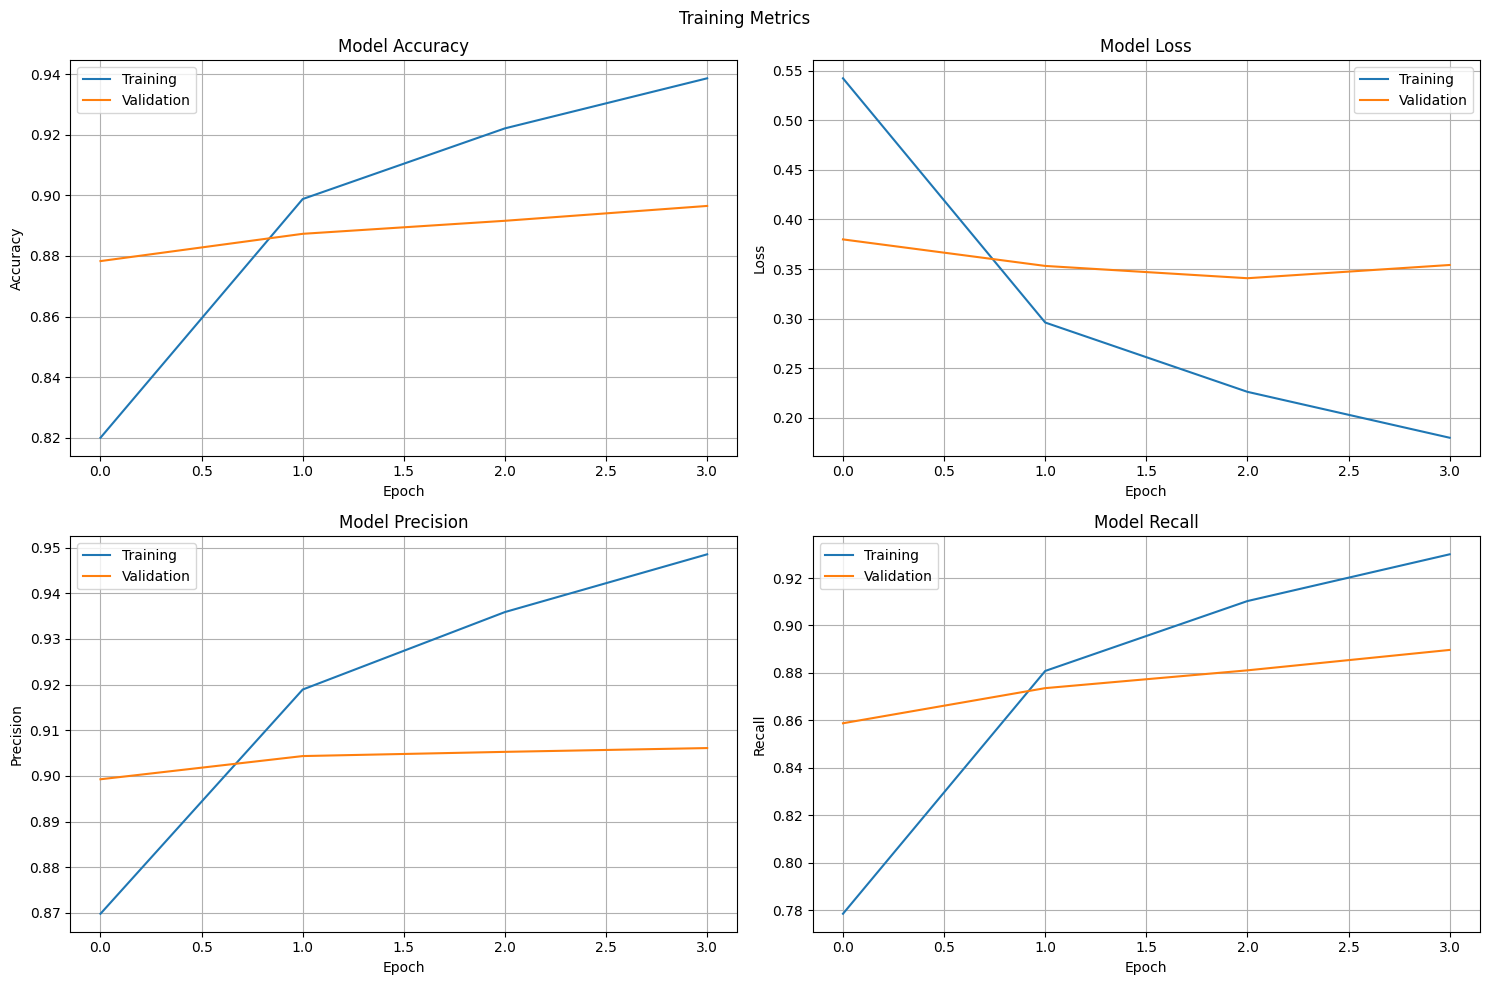

Evaluating model...
Processed 10/313 batches
Processed 20/313 batches
Processed 30/313 batches
Processed 40/313 batches
Processed 50/313 batches
Processed 60/313 batches
Processed 70/313 batches
Processed 80/313 batches
Processed 90/313 batches
Processed 100/313 batches
Processed 110/313 batches
Processed 120/313 batches
Processed 130/313 batches
Processed 140/313 batches
Processed 150/313 batches
Processed 160/313 batches
Processed 170/313 batches
Processed 180/313 batches
Processed 190/313 batches
Processed 200/313 batches
Processed 210/313 batches
Processed 220/313 batches
Processed 230/313 batches
Processed 240/313 batches
Processed 250/313 batches
Processed 260/313 batches
Processed 270/313 batches
Processed 280/313 batches
Processed 290/313 batches
Processed 300/313 batches
Processed 310/313 batches

Generating visualizations...


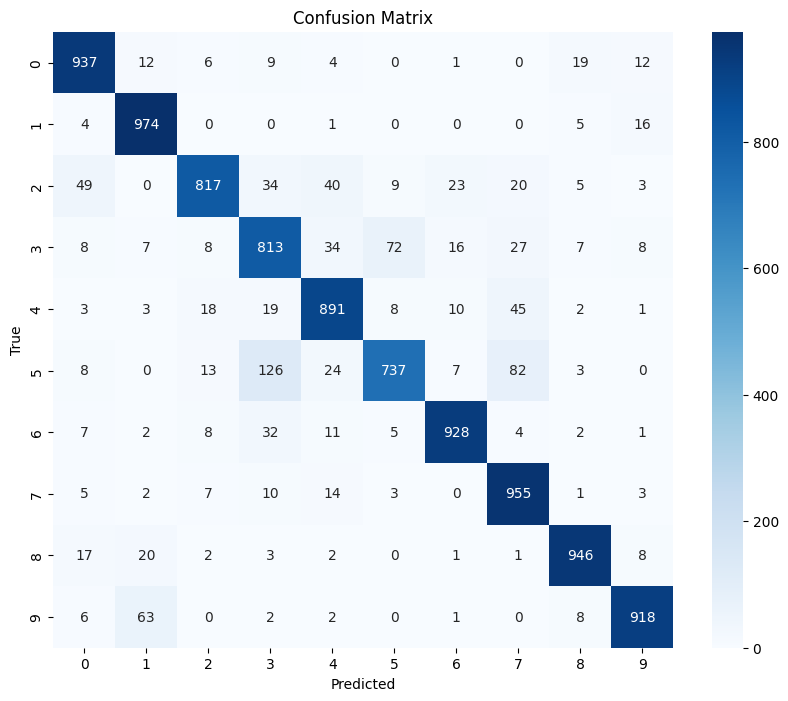


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1000
           1       0.90      0.97      0.94      1000
           2       0.93      0.82      0.87      1000
           3       0.78      0.81      0.79      1000
           4       0.87      0.89      0.88      1000
           5       0.88      0.74      0.80      1000
           6       0.94      0.93      0.93      1000
           7       0.84      0.95      0.90      1000
           8       0.95      0.95      0.95      1000
           9       0.95      0.92      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Visualizing convolutional layers...


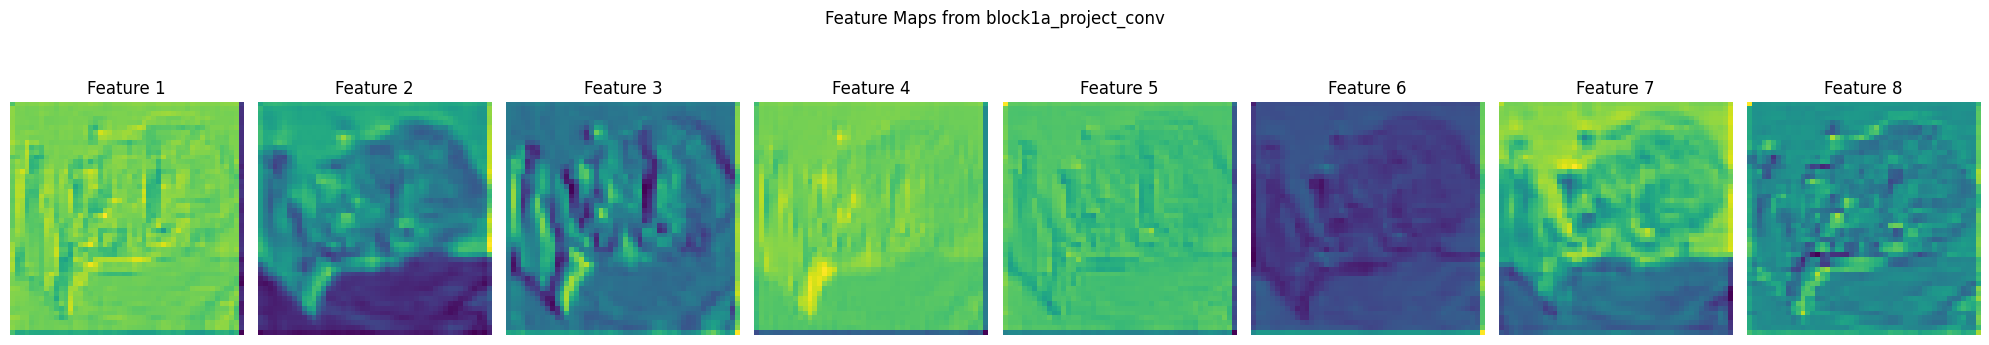

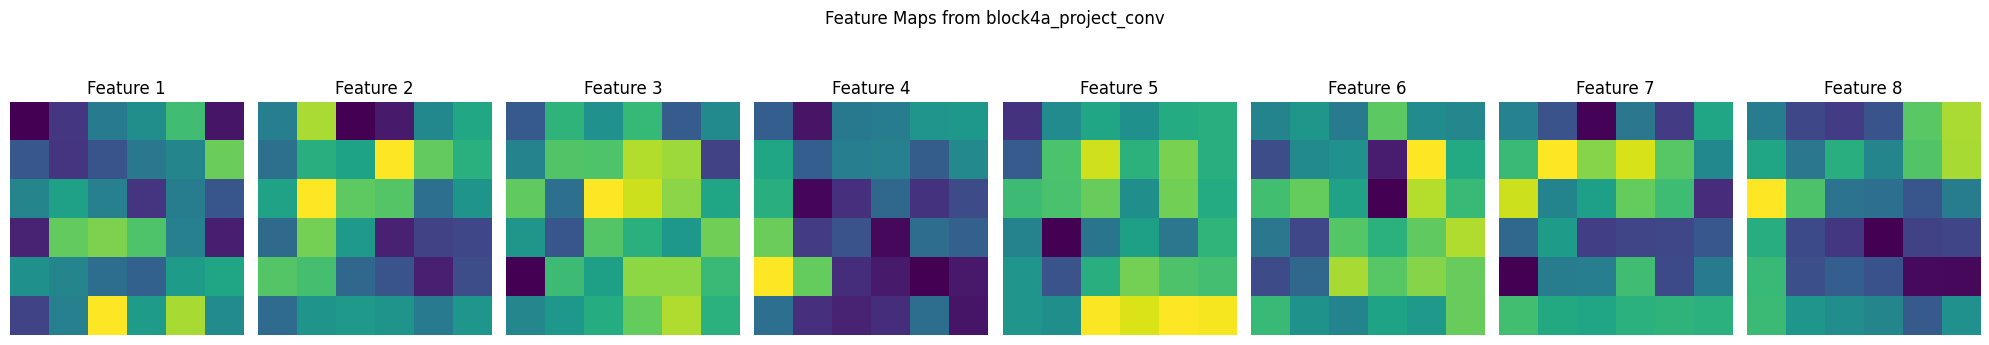

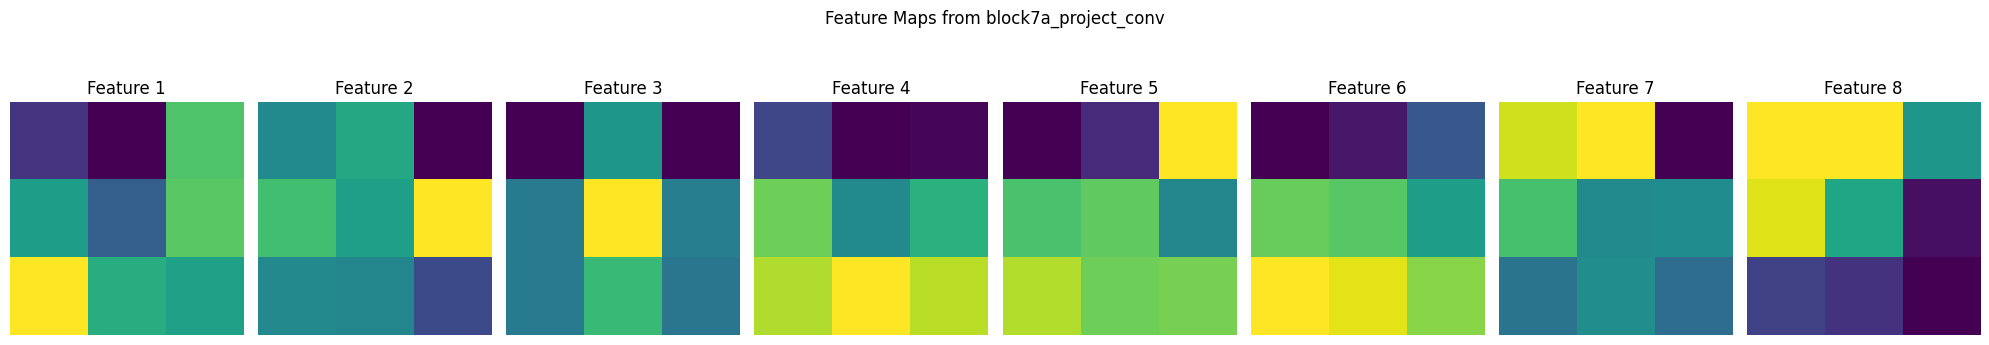


Visualizing final layer features...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


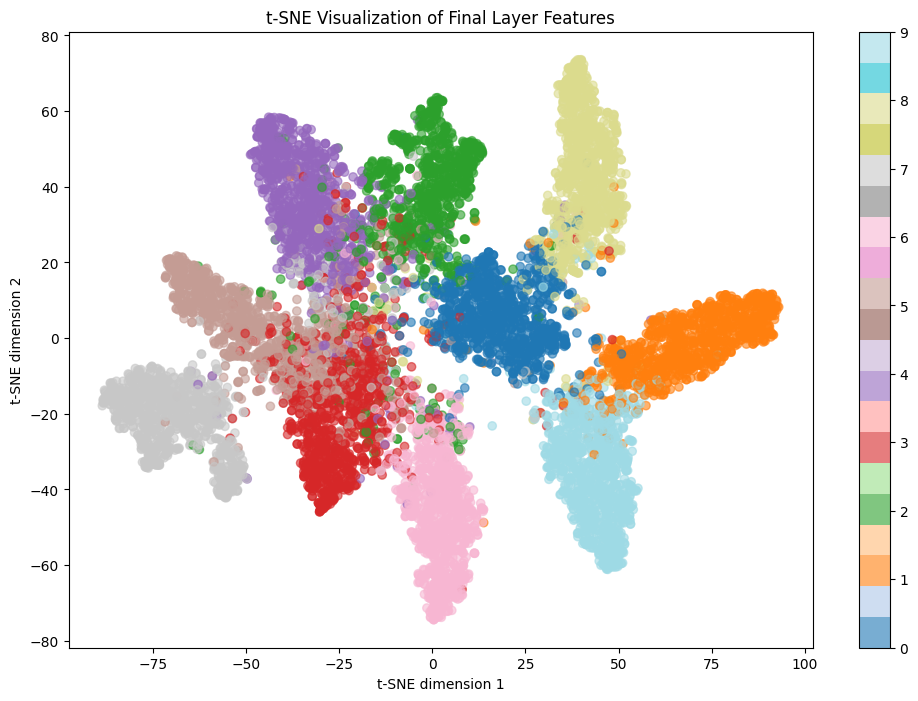


Visualizing class nearest neighbors...


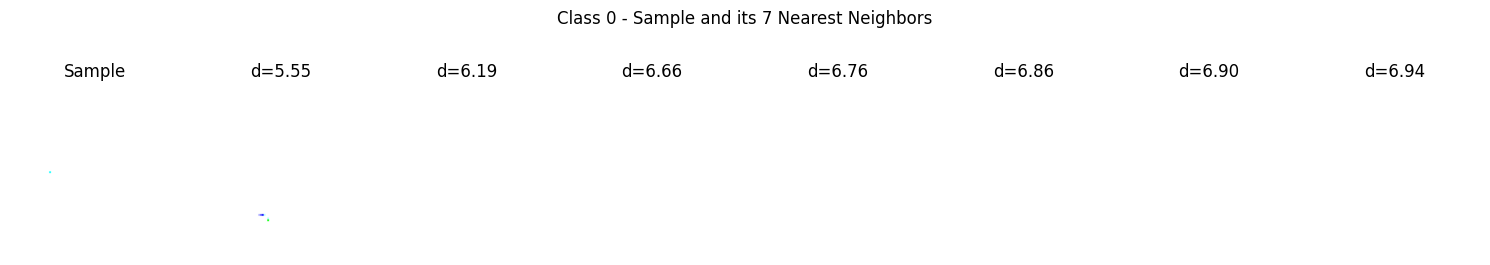

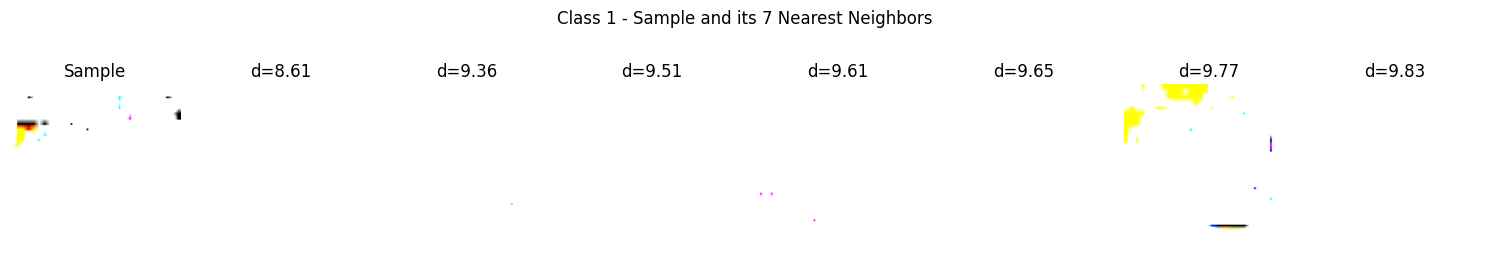

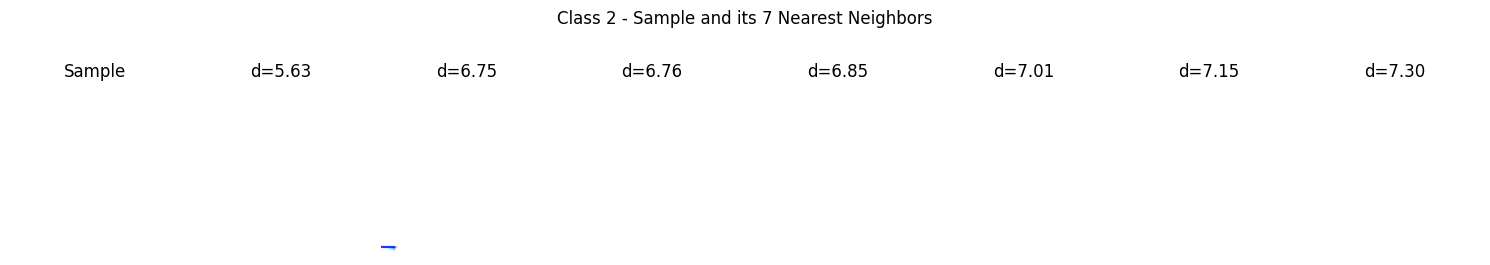

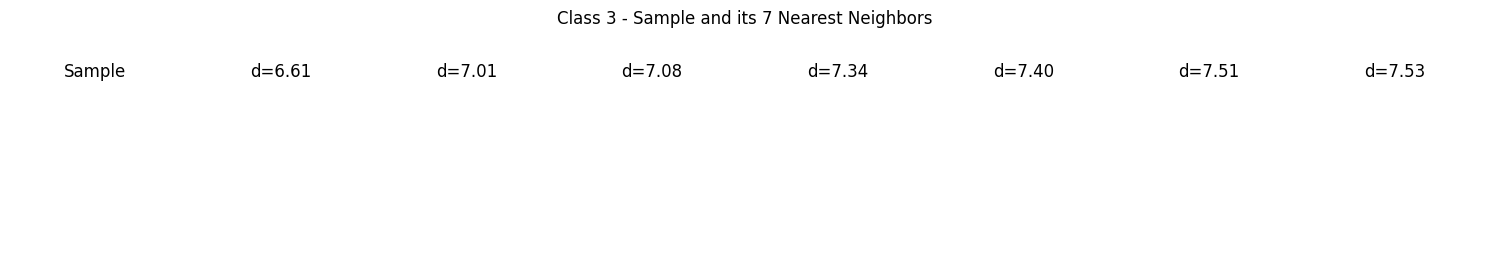

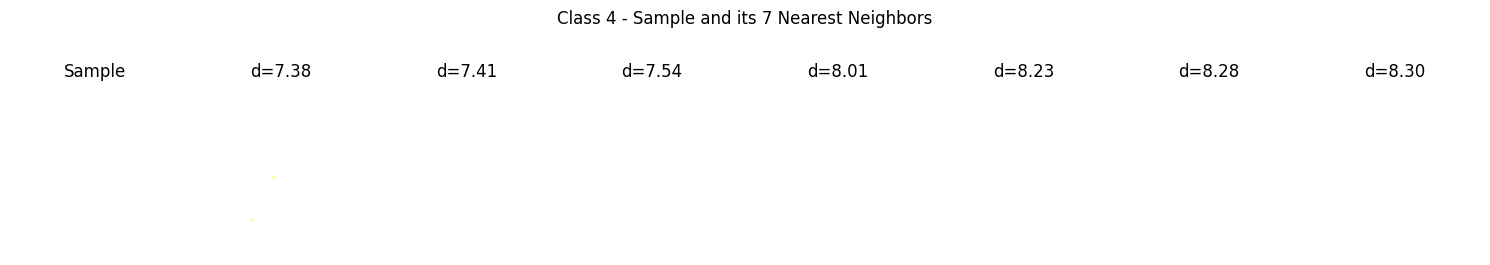

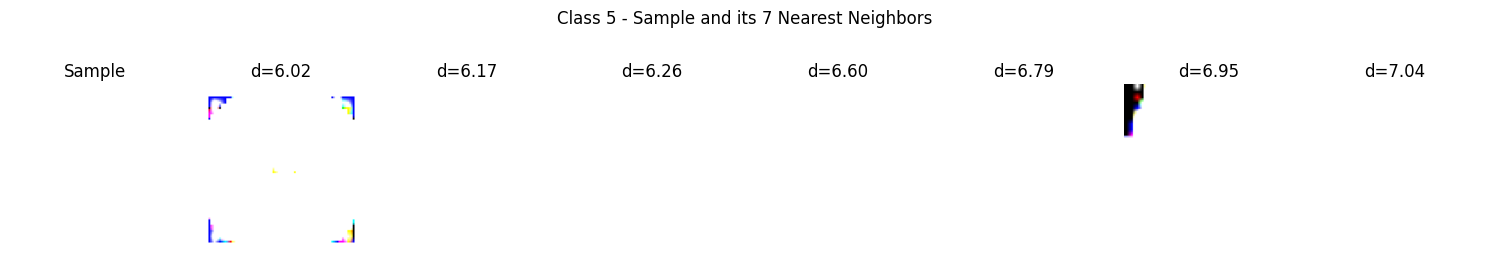

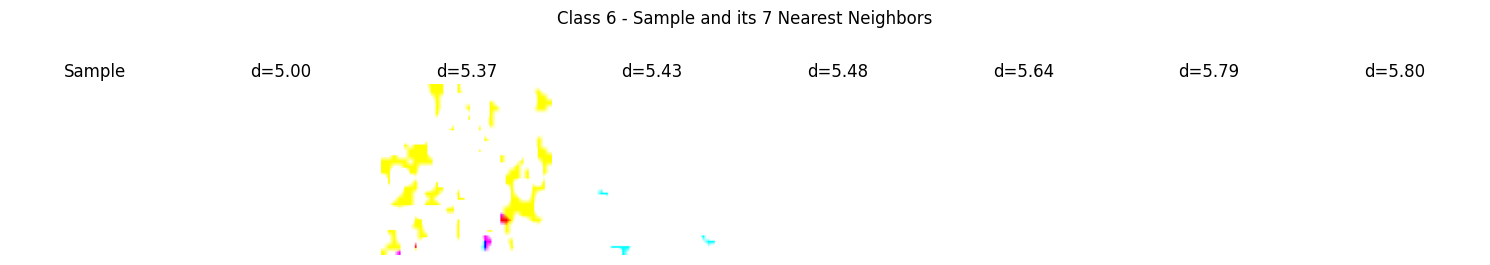

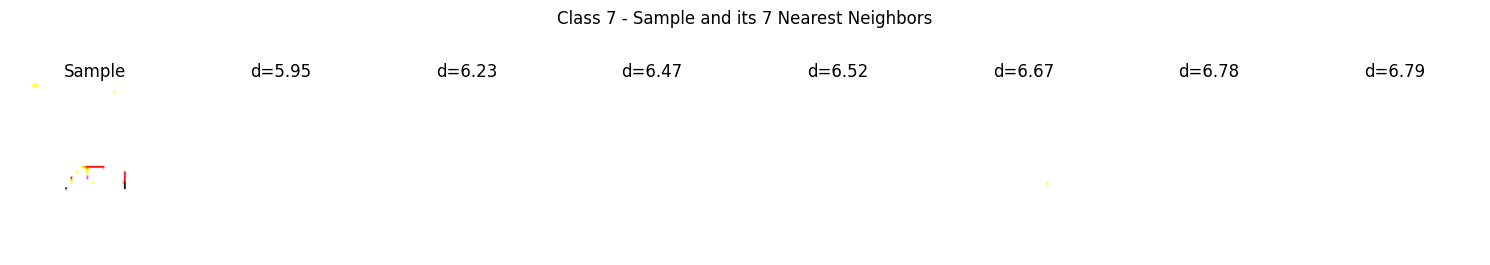

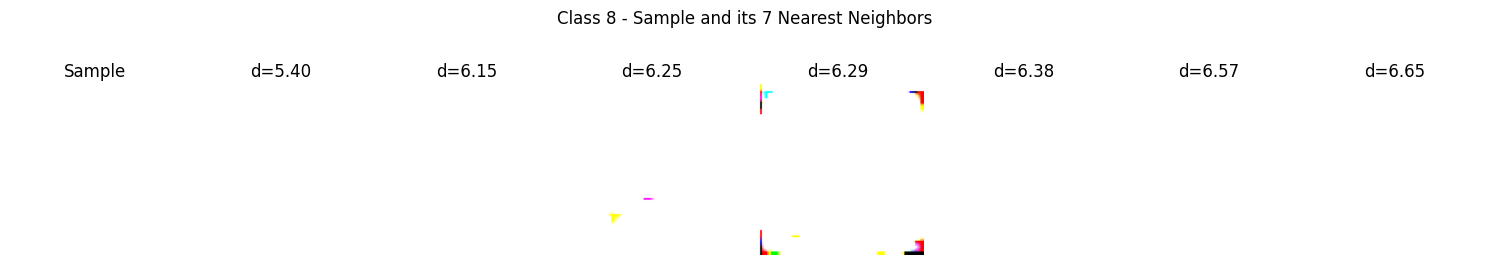

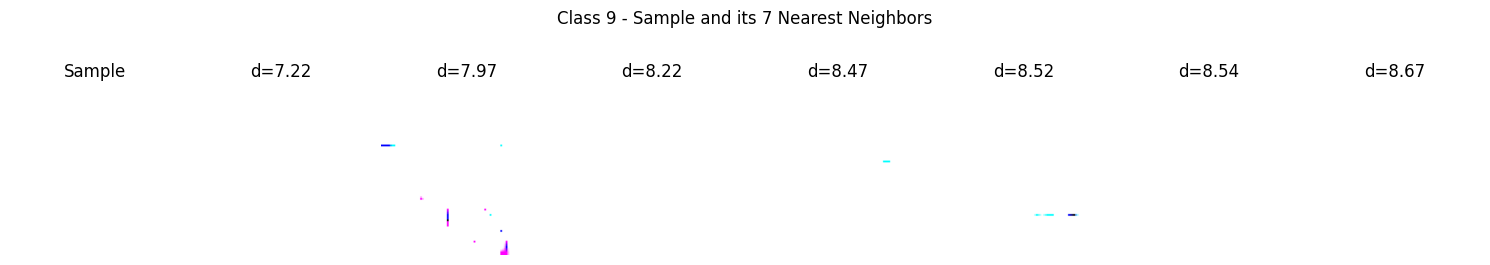

In [5]:

if __name__ == "__main__":
    results = train_and_evaluate(dataset_name='cifar10', epochs=4, batch_size=32, target_size=(96, 96))


Training on CIFAR100
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 160s 68ms/step - accuracy: 0.4069 - loss: 2.4273 - precision_metric: 0.6734 - recall_metric: 0.2699 - val_accuracy: 0.6499 - val_loss: 1.2788 - val_precision_metric: 0.7688 - val_recall_metric: 0.5722 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.6812 - loss: 1.0975 - precision_metric: 0.8079 - recall_metric: 0.5837 - val_accuracy: 0.6801 - val_loss: 1.1633 - val_precision_metric: 0.7839 - val_recall_metric: 0.6192 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 44ms/step - accuracy: 0.7558 - loss: 0.8206 - precision_metric: 0.8495 - recall_metric: 0.6831 - val_accuracy: 0.6875 - val_loss: 1.1843 - val_precision_metric: 0.7772 - val_recall_metric: 0.6385 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 69s 44ms/step - accuracy: 0.8029 - loss: 0.6413 - precision_metric: 0.8717 - recall_metric: 0.7468 - val_accuracy: 0.6888 - val_loss: 1.2562 - val_precision_metric: 0.759

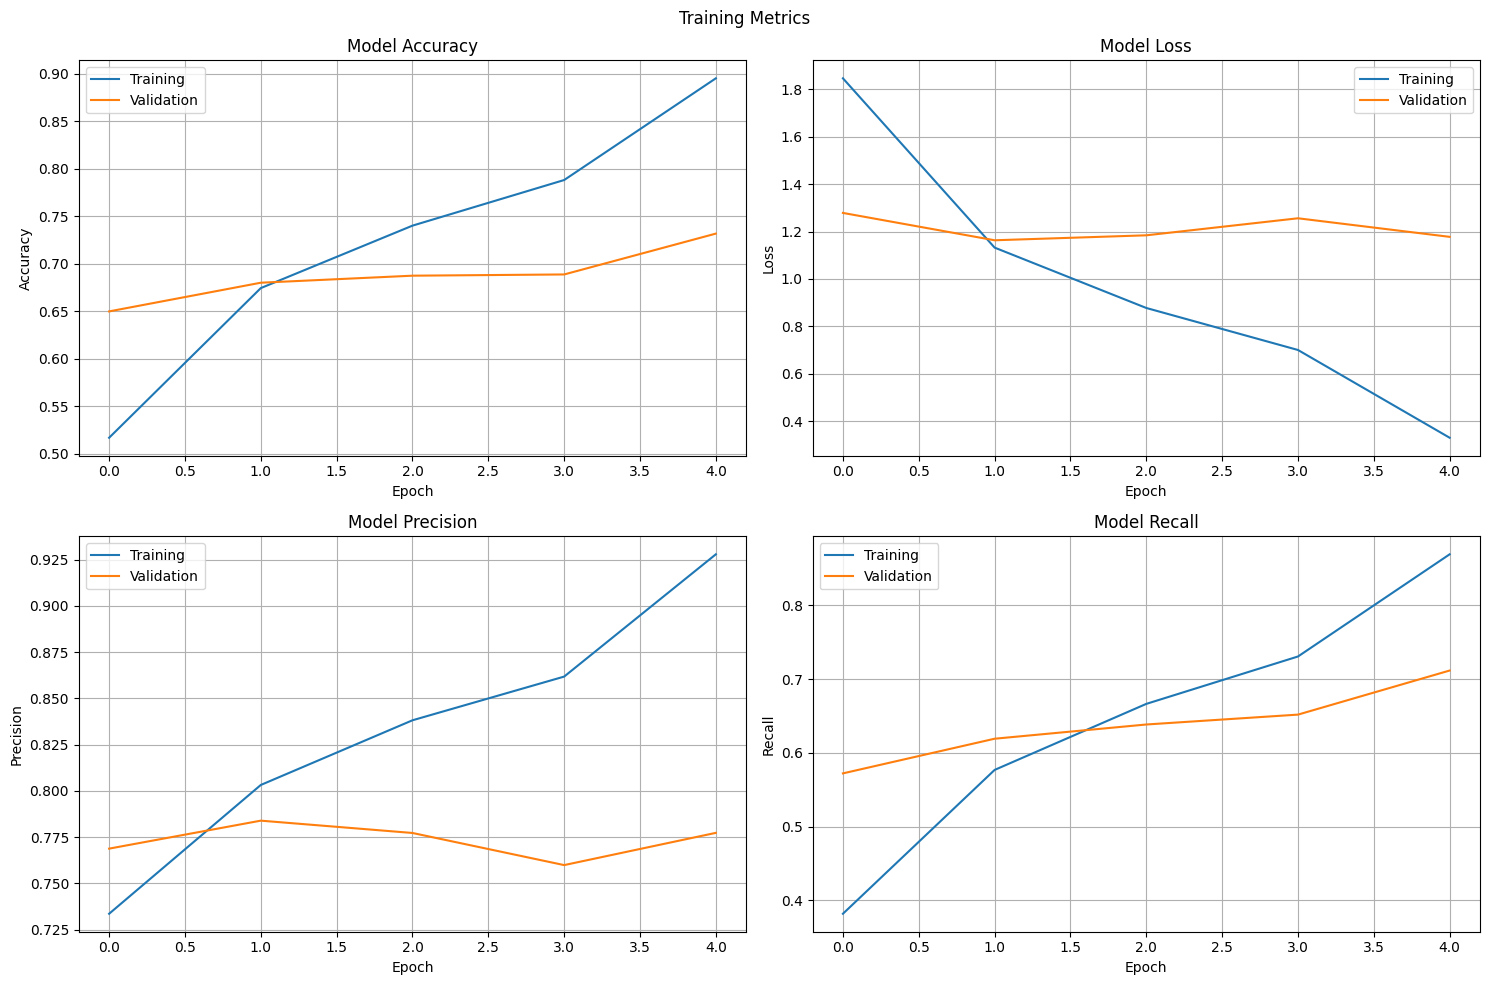

Evaluating model...
Processed 10/313 batches
Processed 20/313 batches
Processed 30/313 batches
Processed 40/313 batches
Processed 50/313 batches
Processed 60/313 batches
Processed 70/313 batches
Processed 80/313 batches
Processed 90/313 batches
Processed 100/313 batches
Processed 110/313 batches
Processed 120/313 batches
Processed 130/313 batches
Processed 140/313 batches
Processed 150/313 batches
Processed 160/313 batches
Processed 170/313 batches
Processed 180/313 batches
Processed 190/313 batches
Processed 200/313 batches
Processed 210/313 batches
Processed 220/313 batches
Processed 230/313 batches
Processed 240/313 batches
Processed 250/313 batches
Processed 260/313 batches
Processed 270/313 batches
Processed 280/313 batches
Processed 290/313 batches
Processed 300/313 batches
Processed 310/313 batches

Generating visualizations...


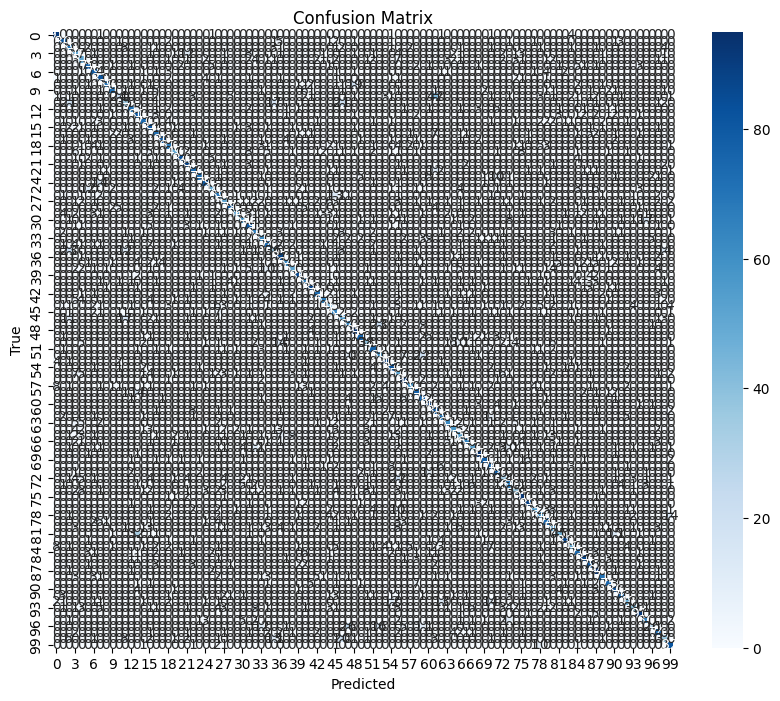


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       100
           1       0.79      0.80      0.80       100
           2       0.48      0.69      0.56       100
           3       0.43      0.50      0.47       100
           4       0.45      0.51      0.48       100
           5       0.75      0.75      0.75       100
           6       0.70      0.79      0.74       100
           7       0.61      0.82      0.70       100
           8       0.95      0.69      0.80       100
           9       0.86      0.71      0.78       100
          10       0.63      0.24      0.35       100
          11       0.41      0.35      0.38       100
          12       0.81      0.71      0.76       100
          13       0.54      0.80      0.64       100
          14       0.79      0.73      0.76       100
          15       0.59      0.81      0.68       100
          16       0.66      0.71      0.69       100
   

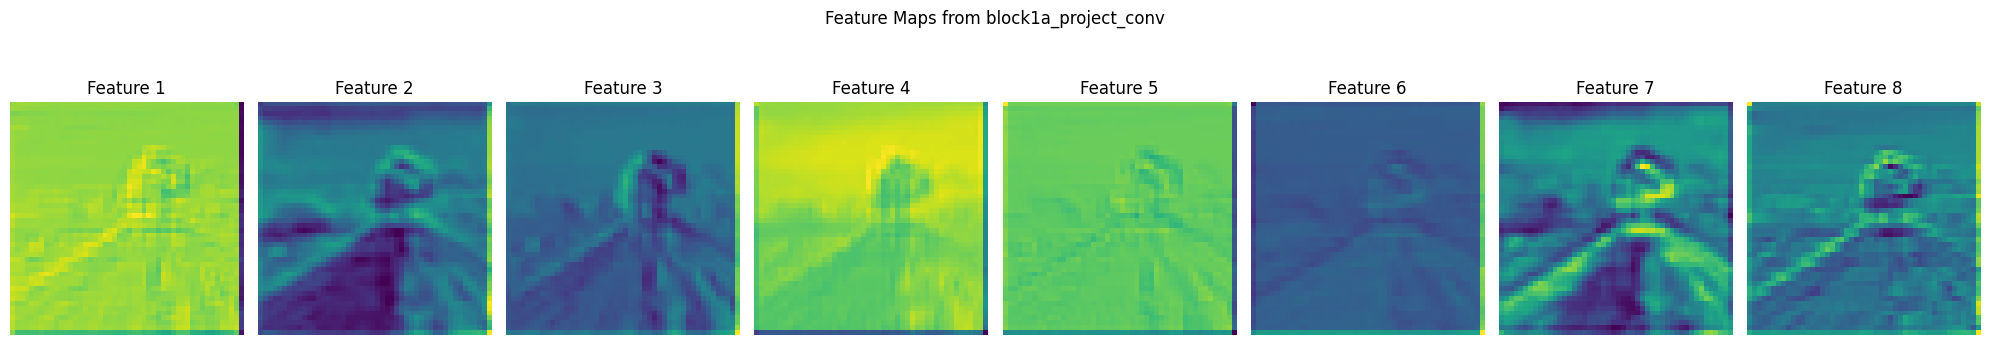

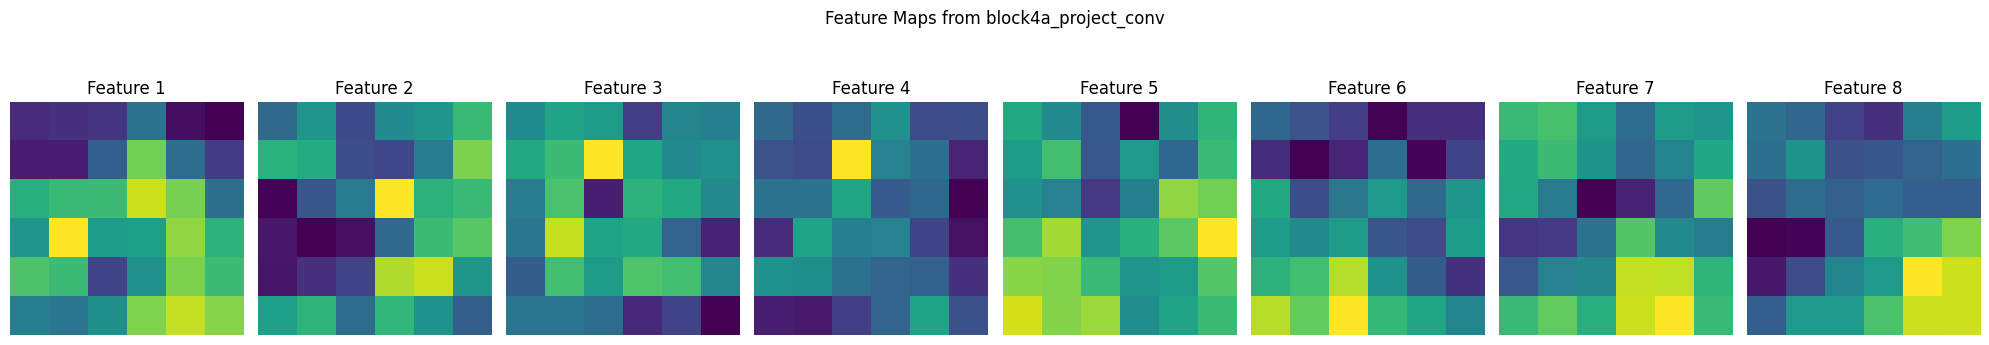

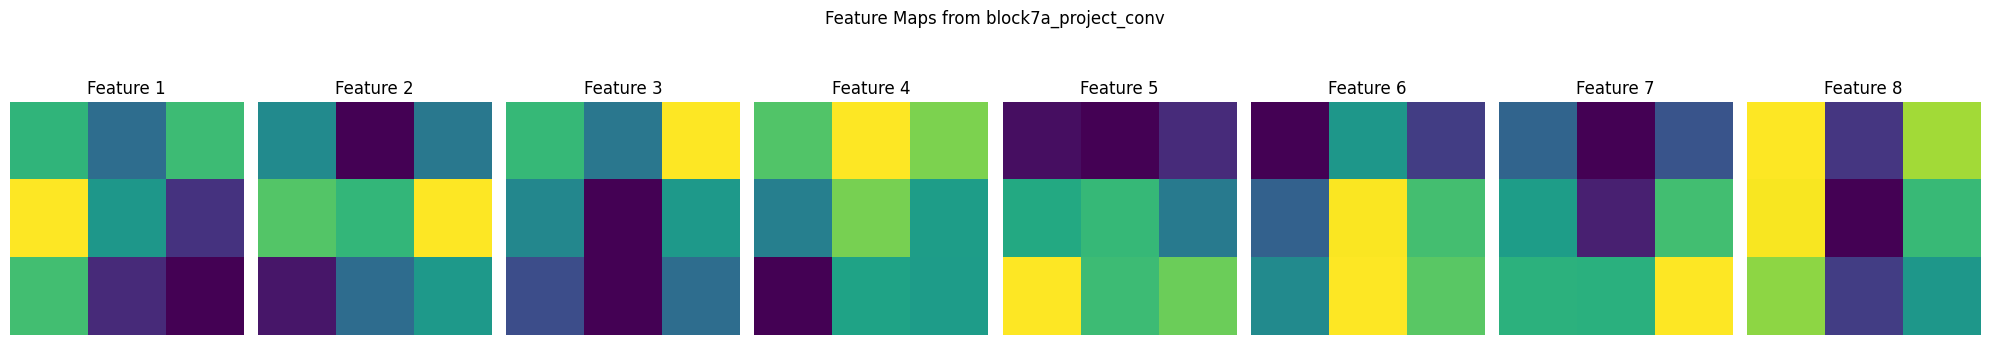


Visualizing final layer features...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


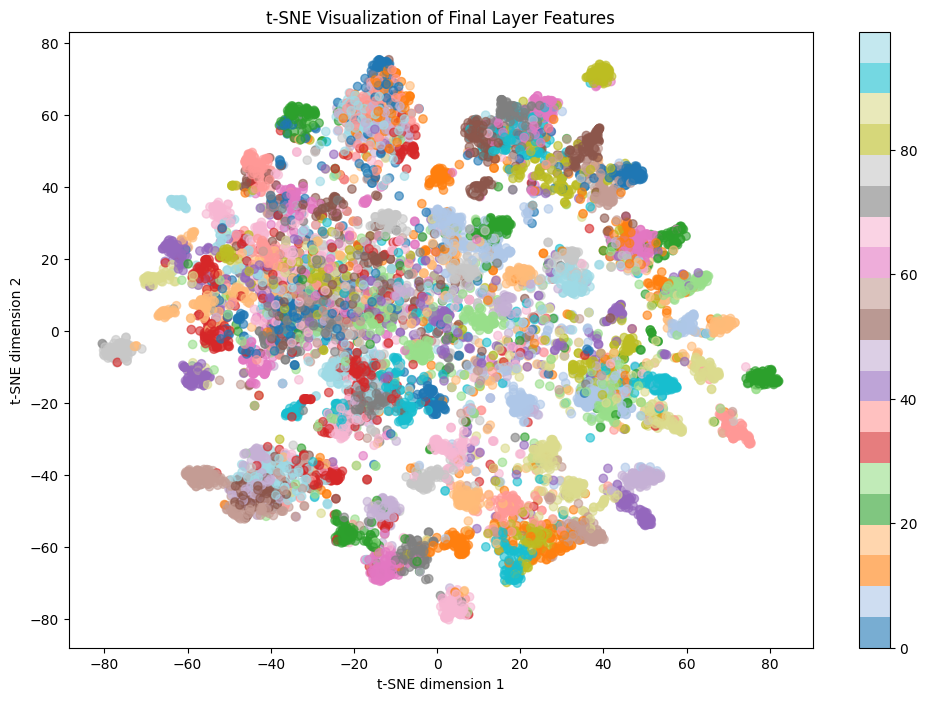


Visualizing class nearest neighbors...


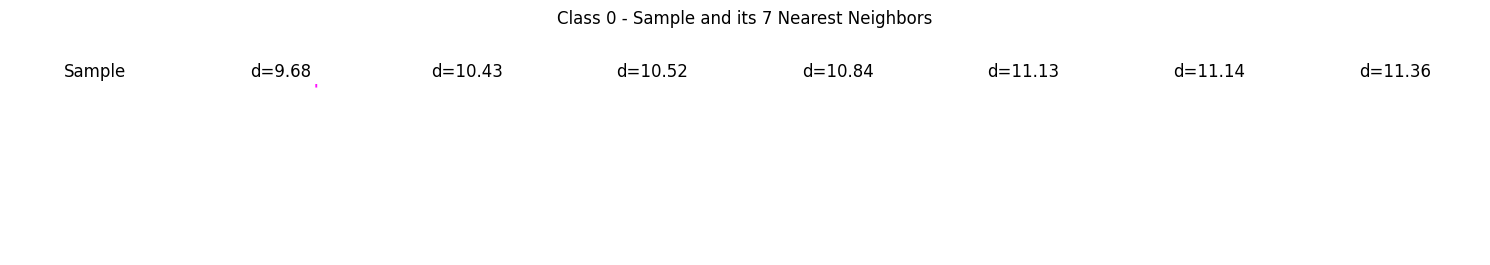

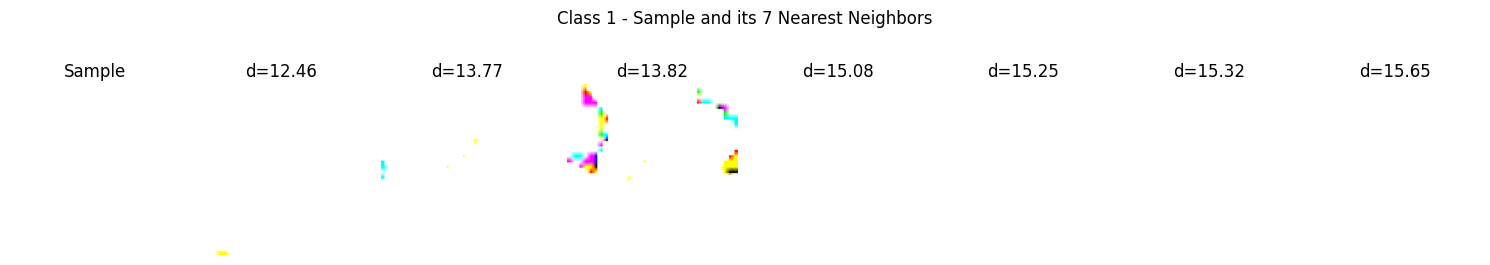

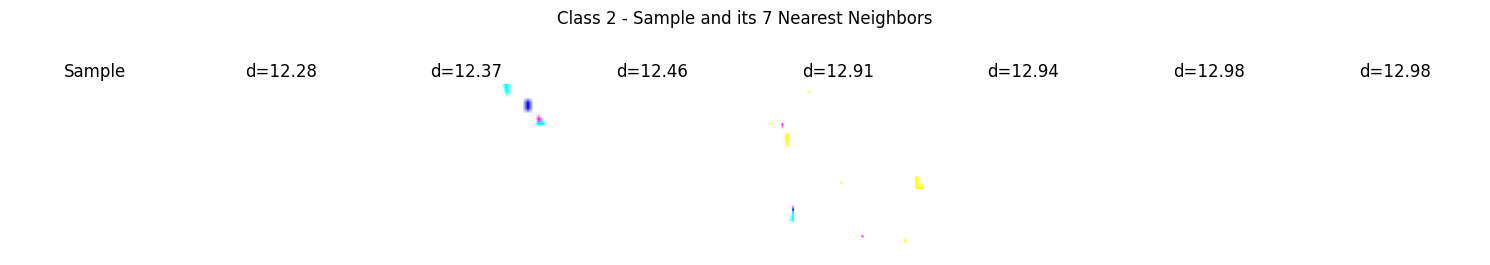

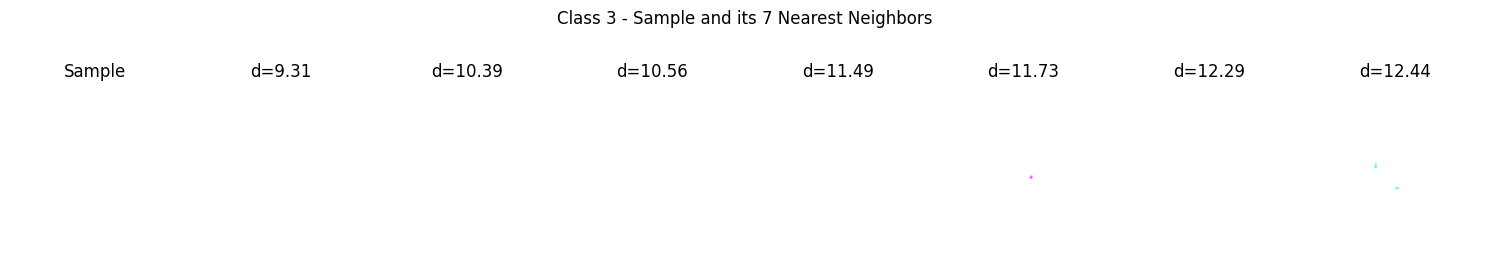

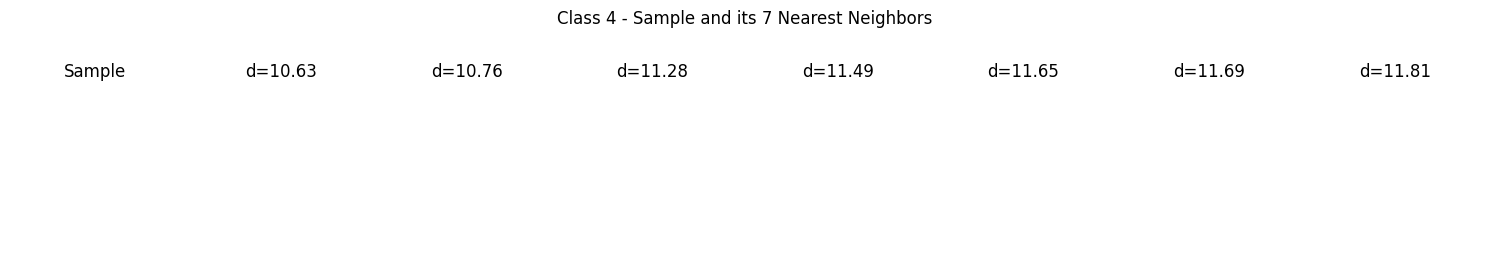

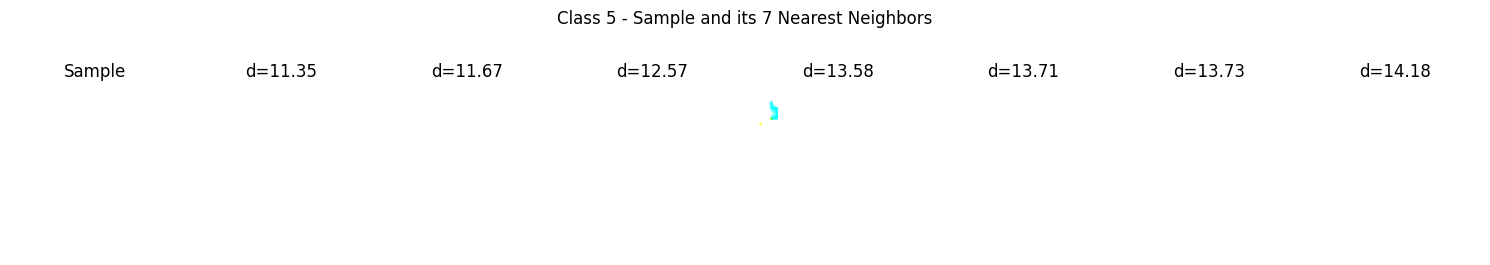

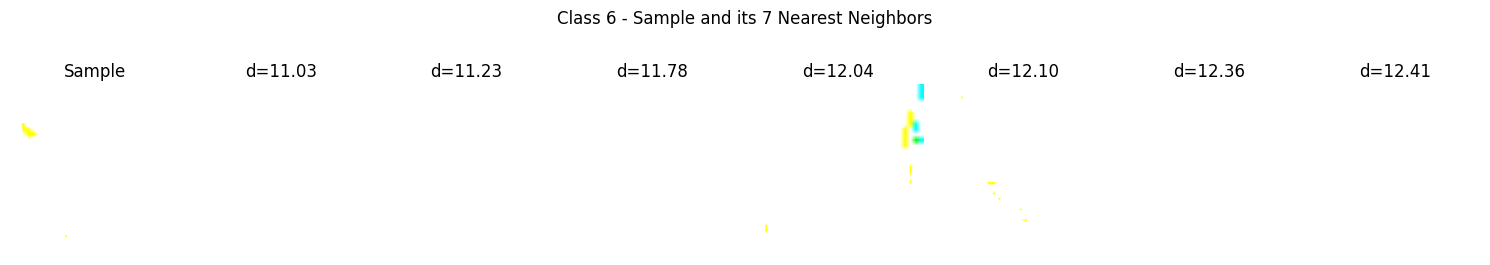

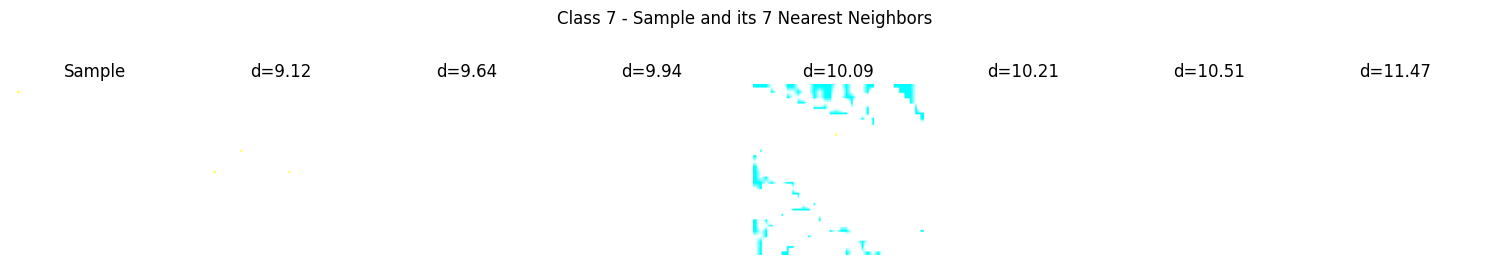

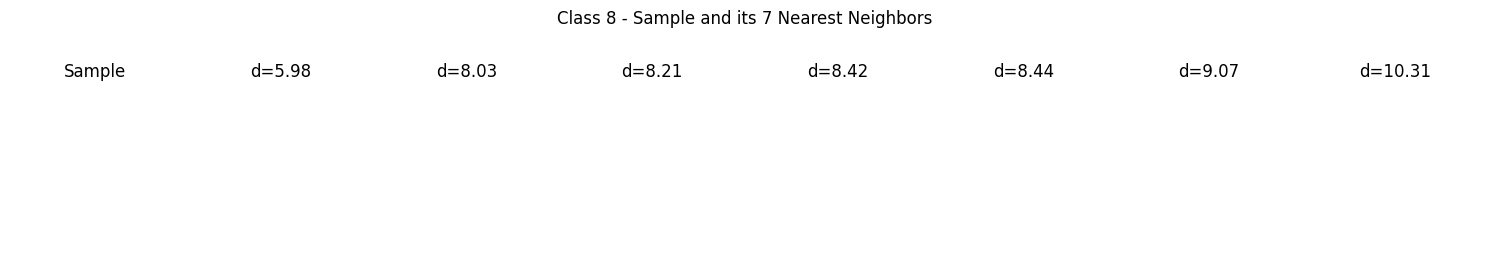

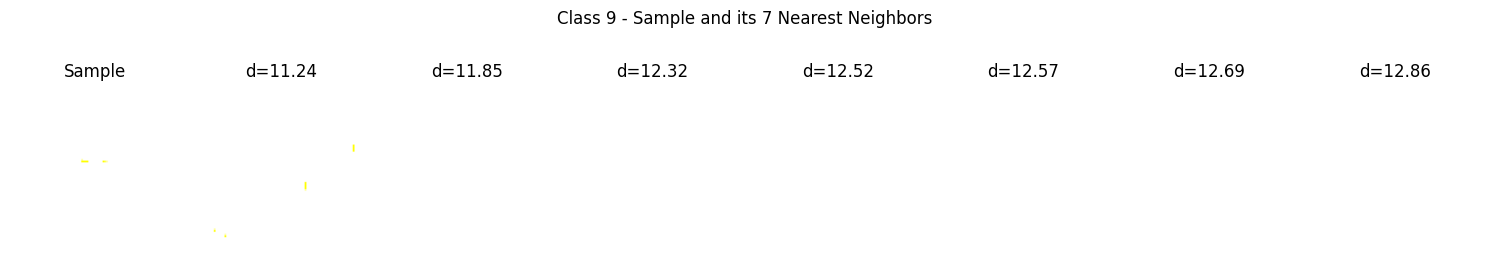

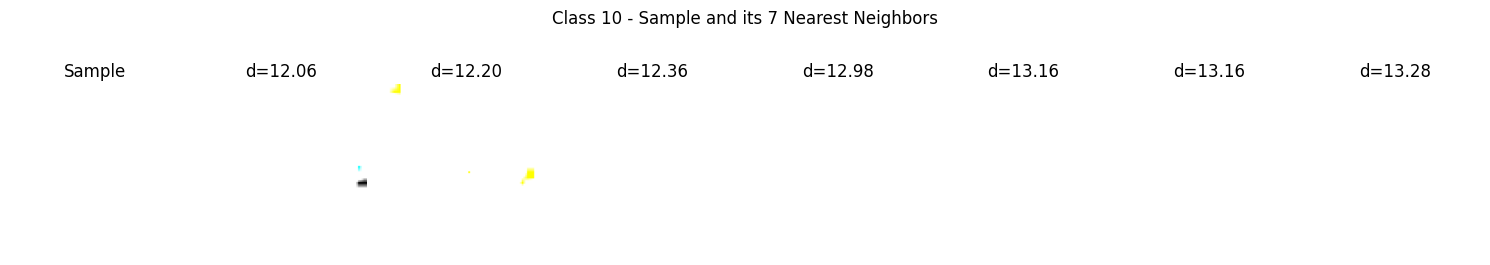

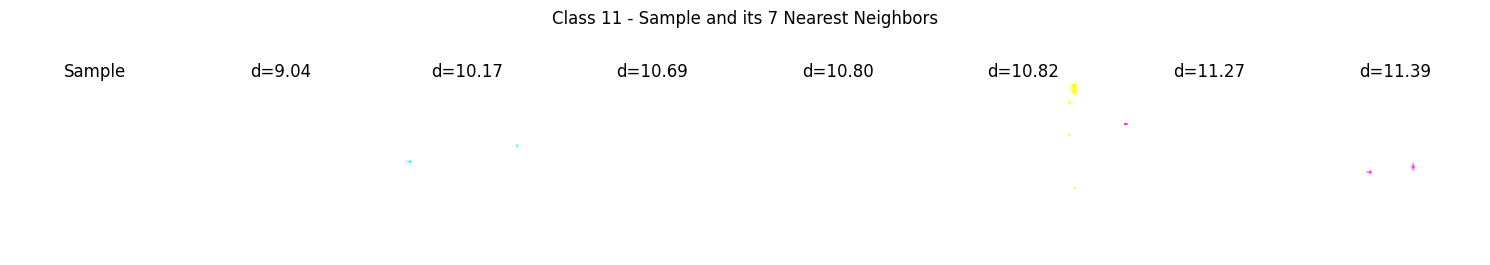

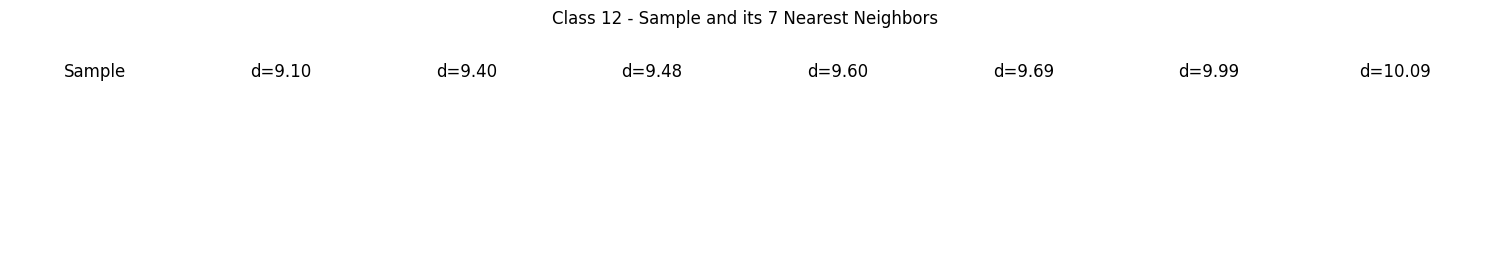

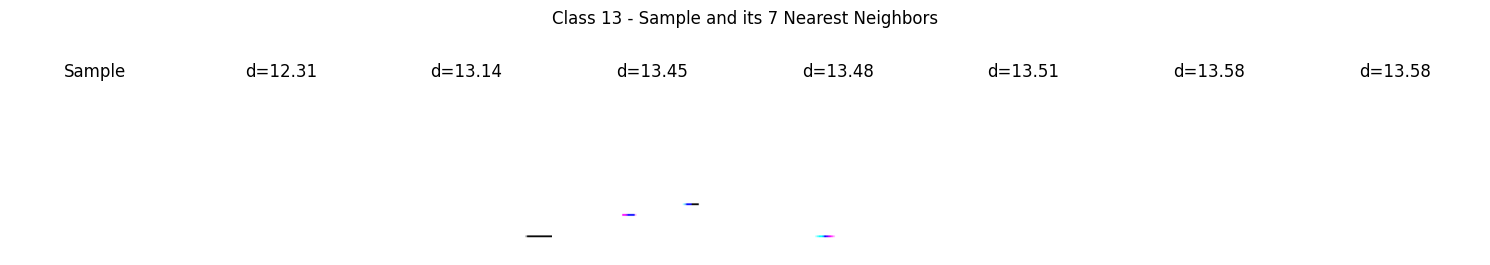

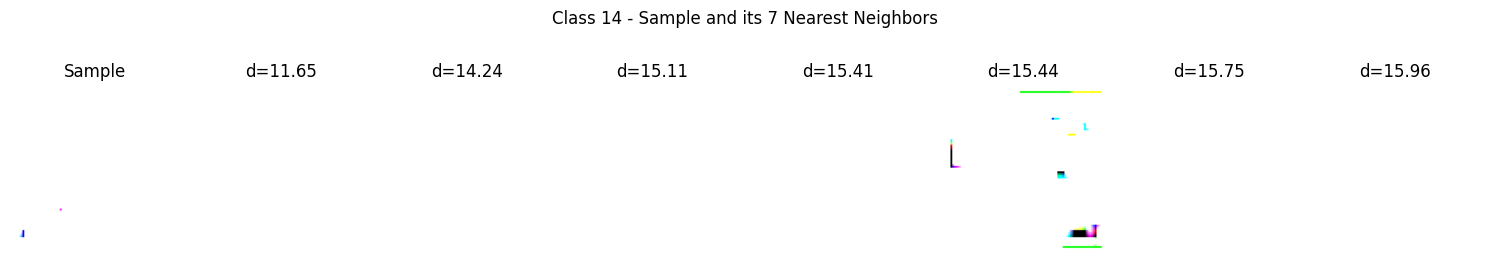

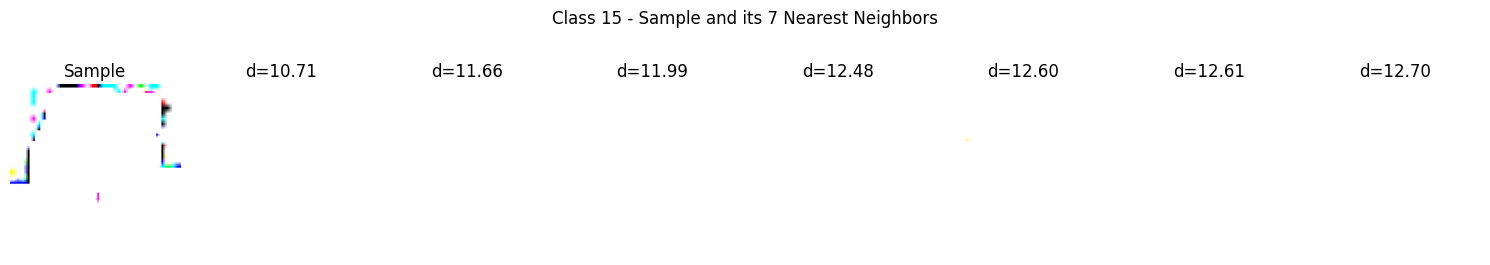

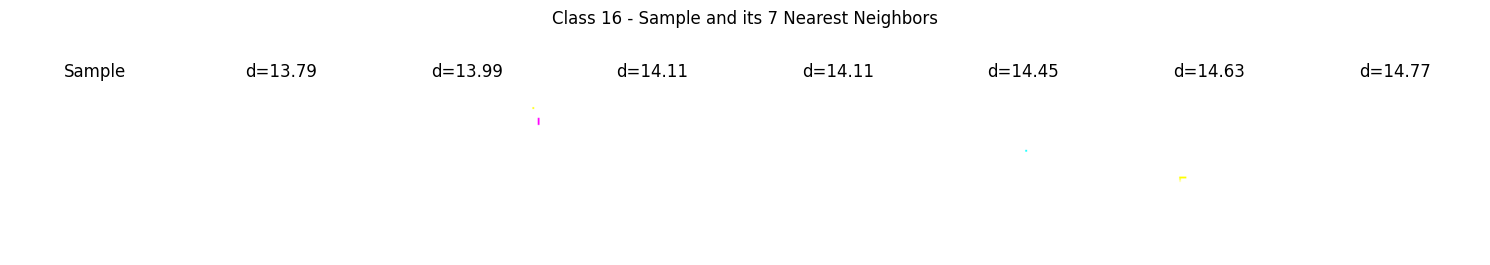

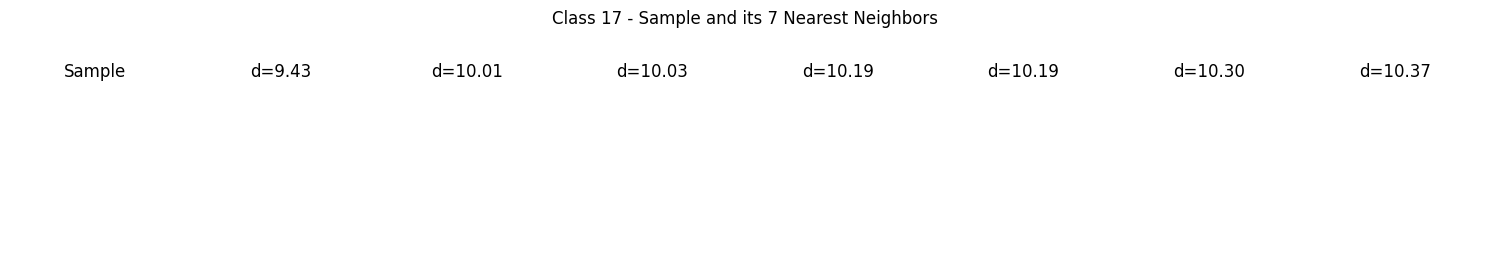

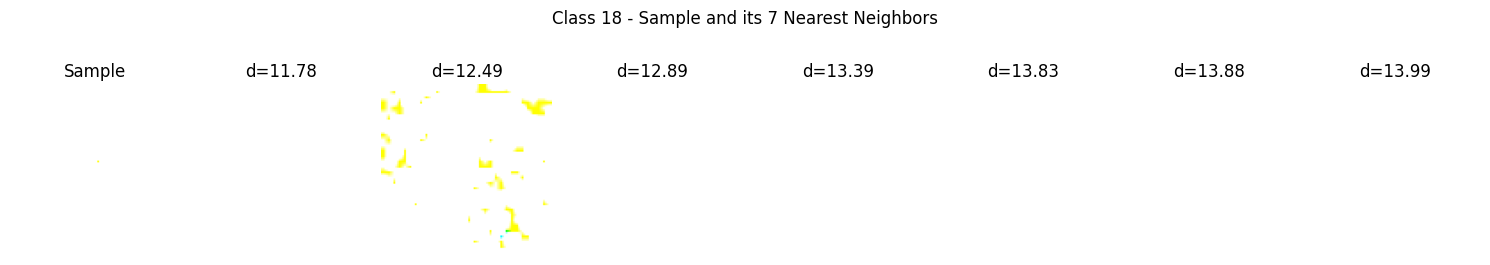

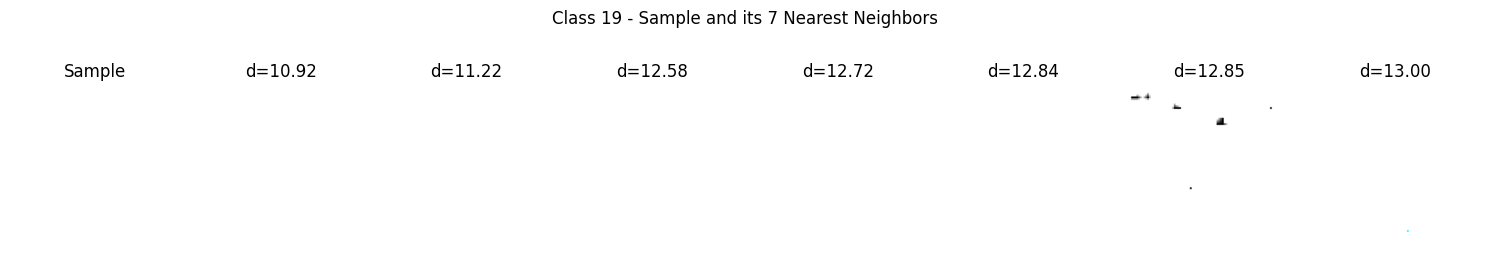

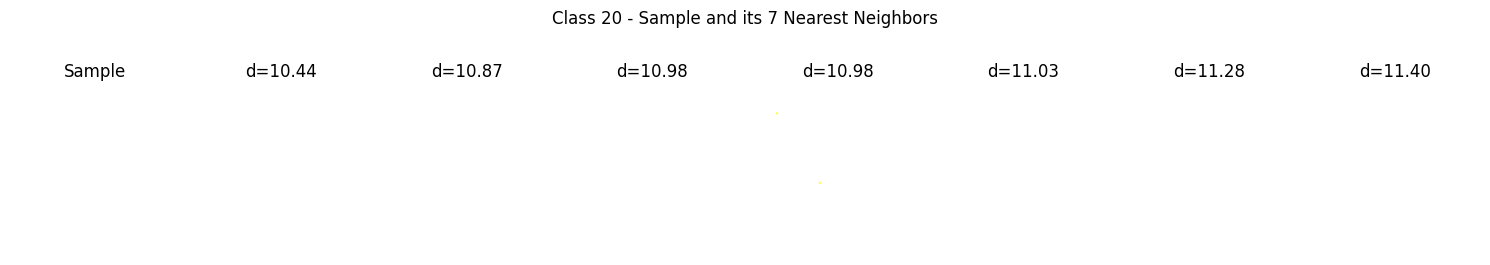

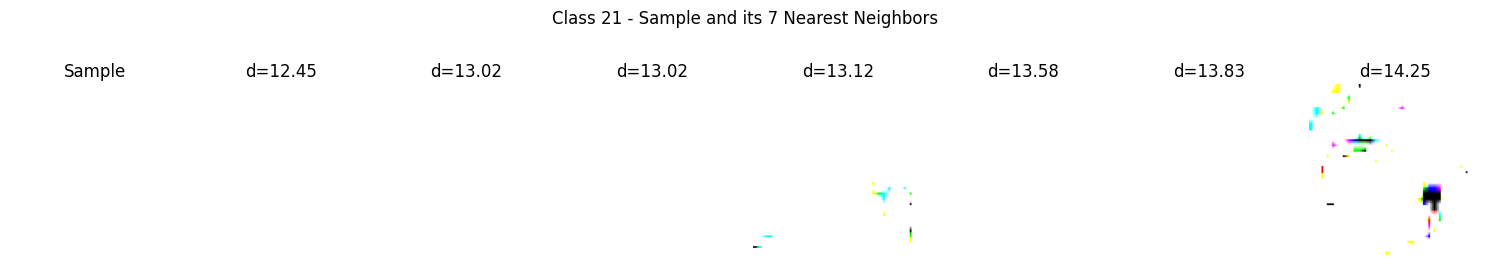

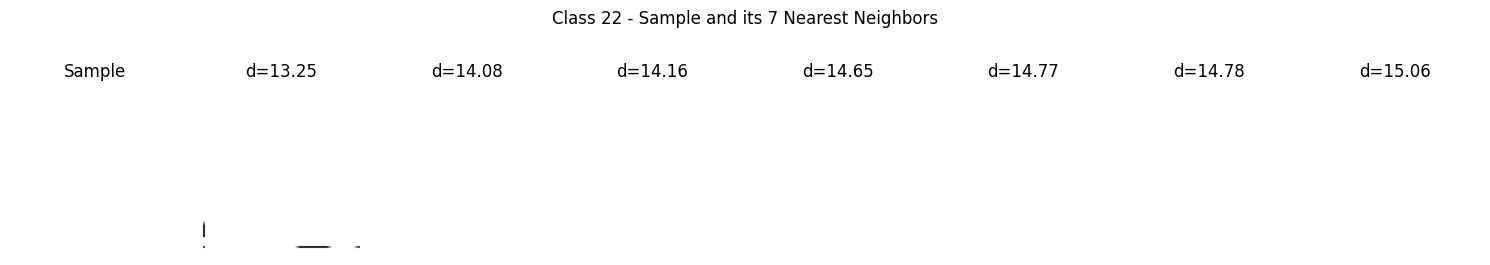

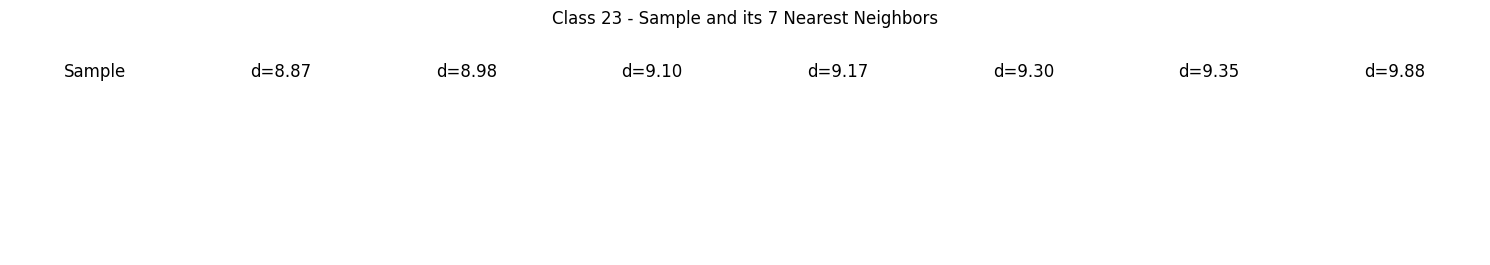

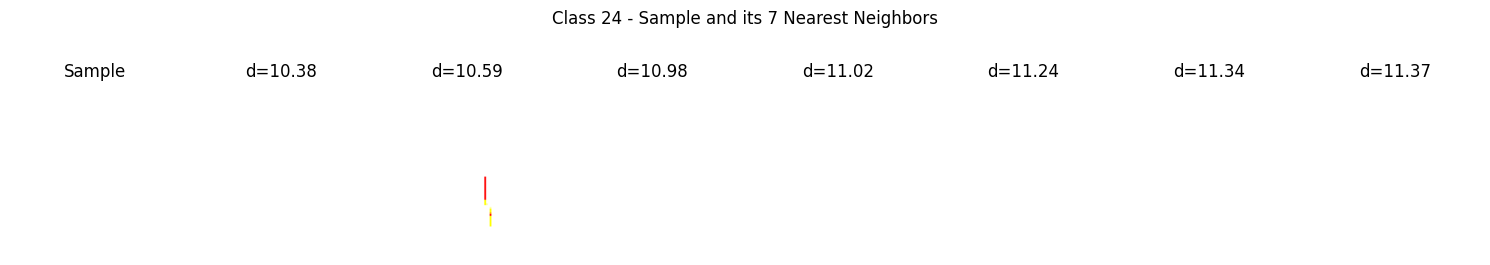

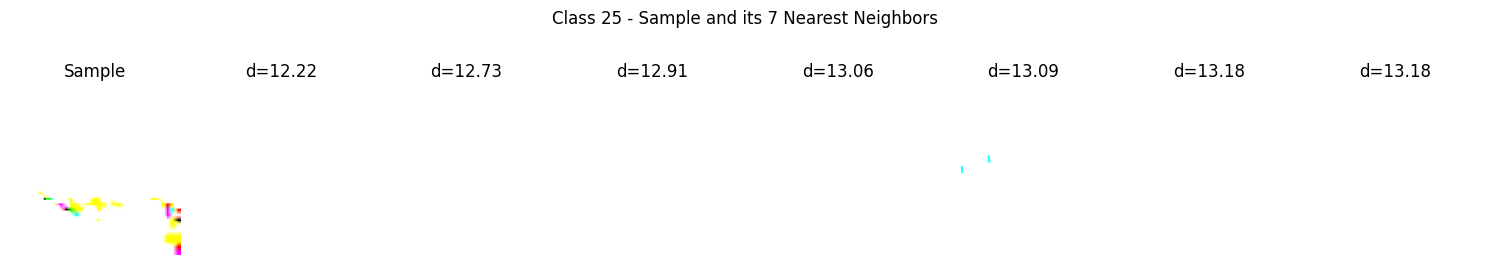

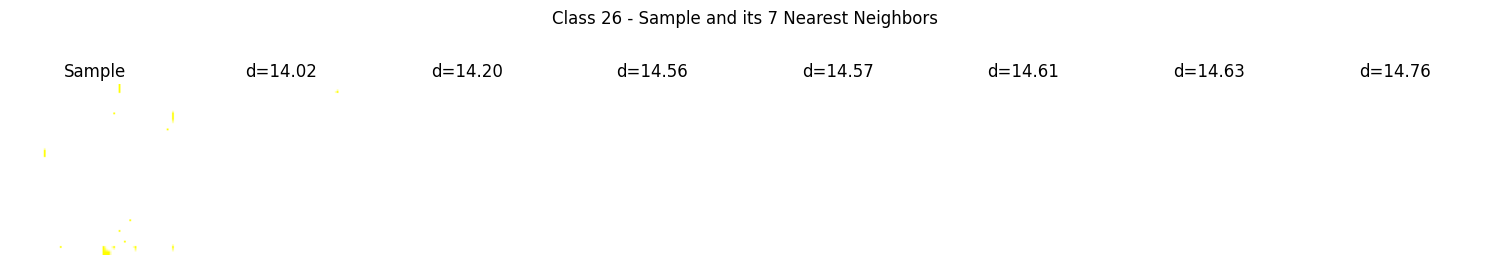

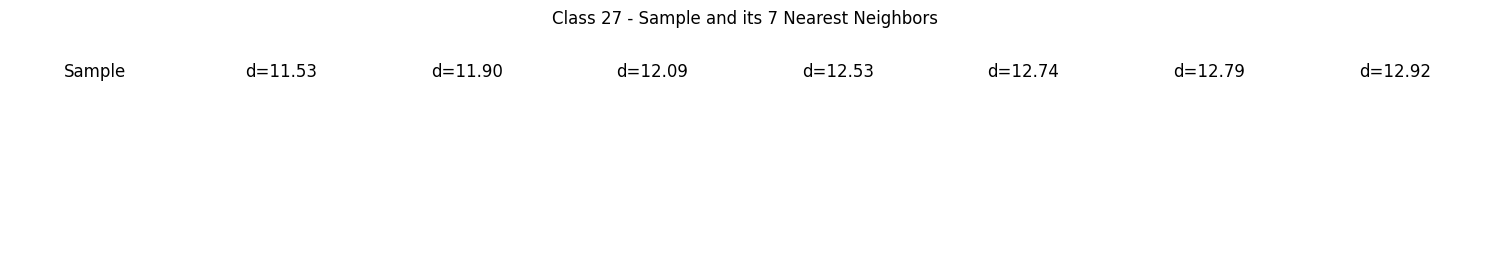

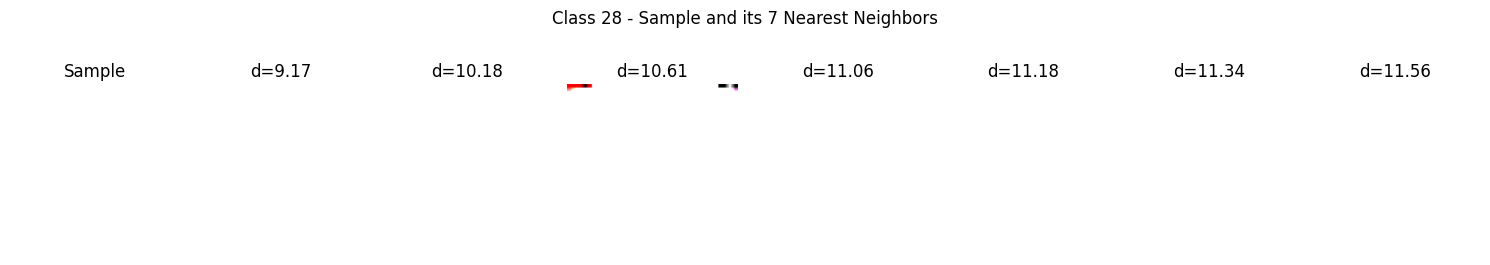

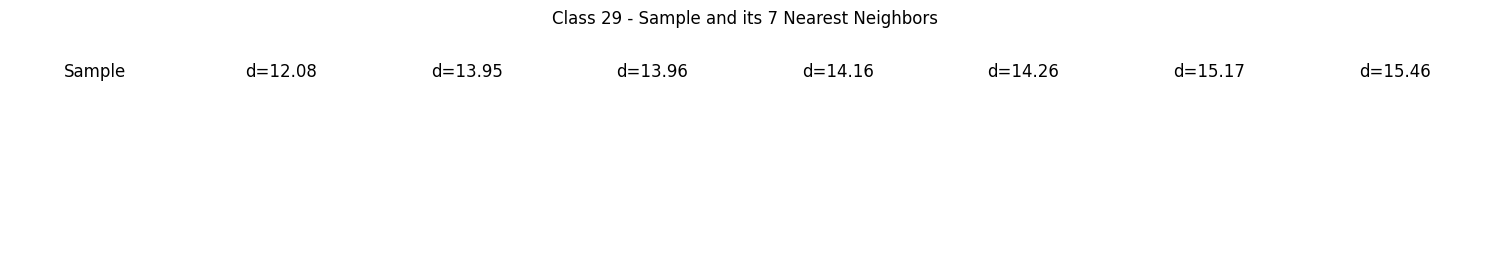

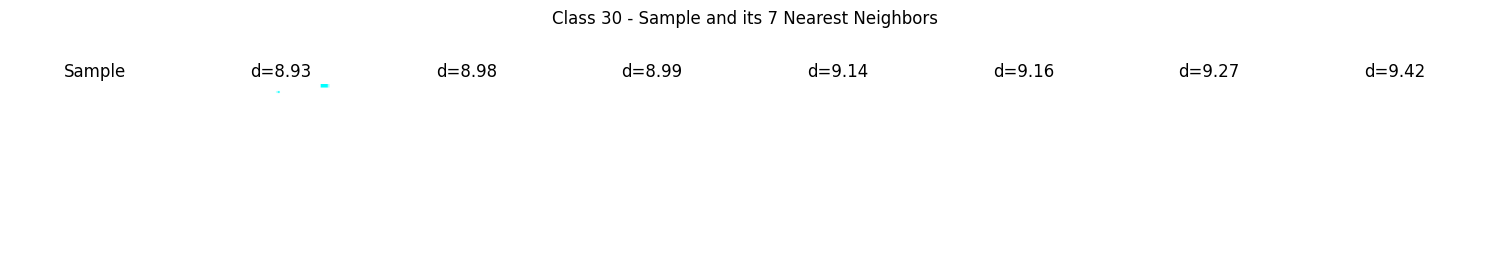

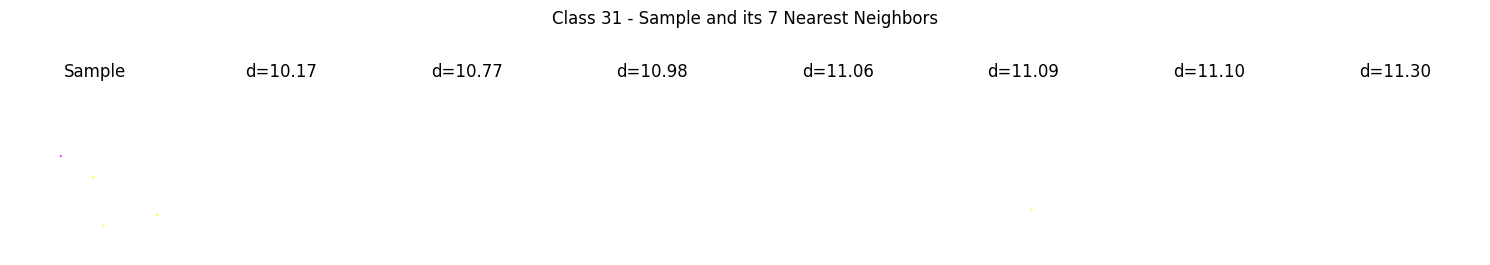

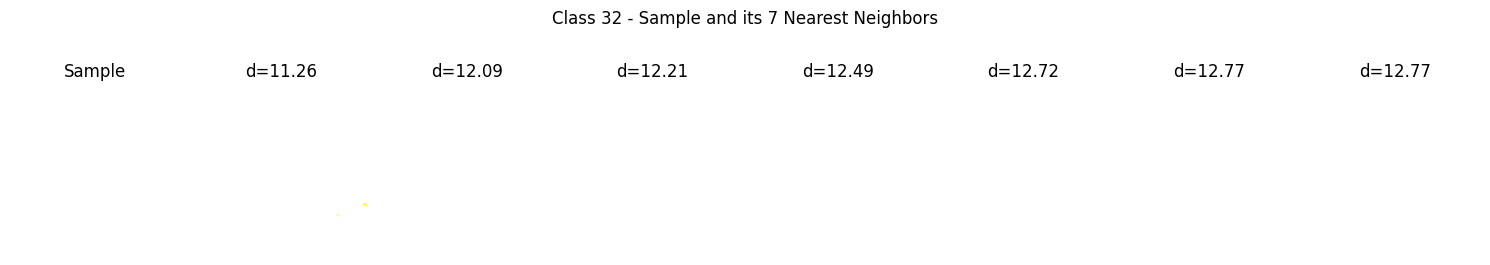

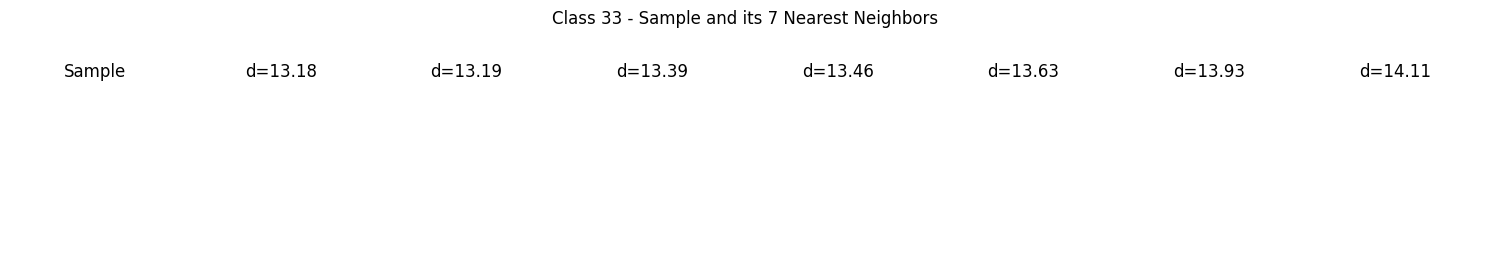

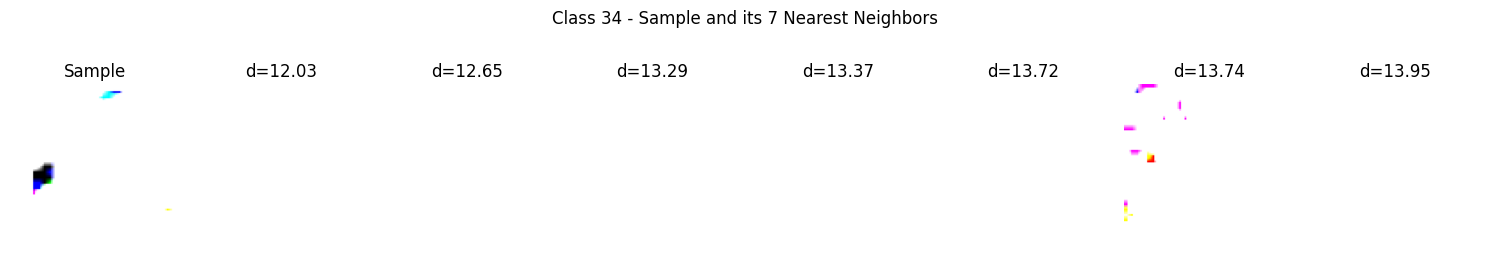

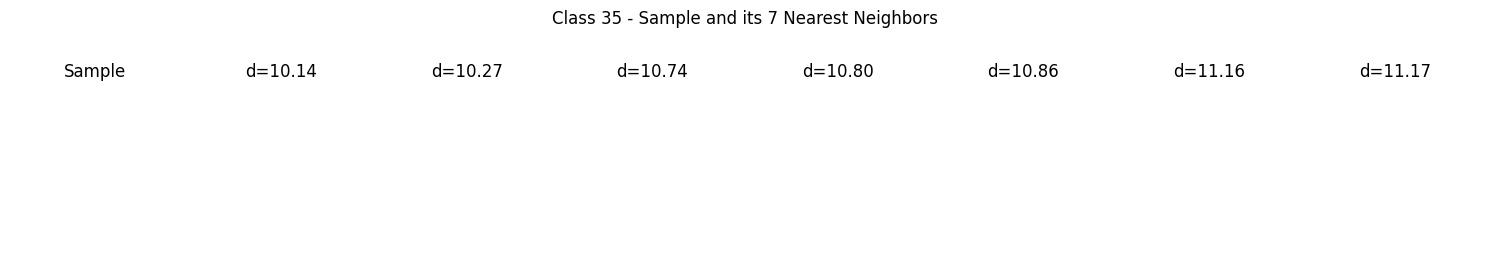

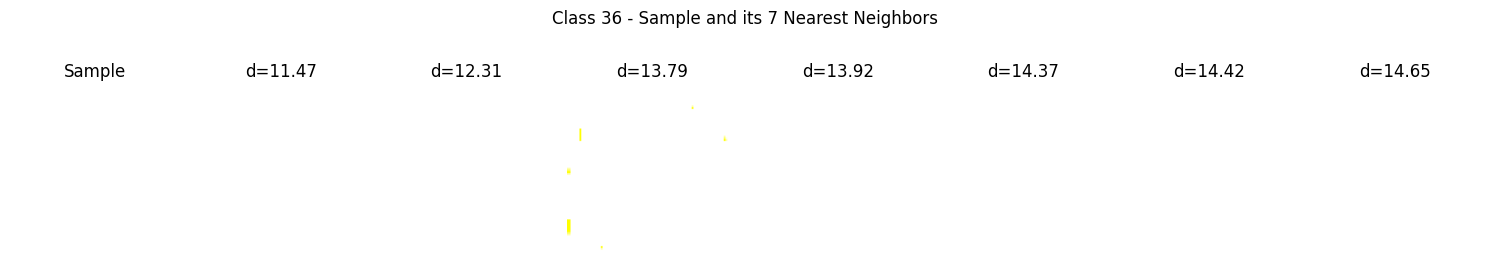

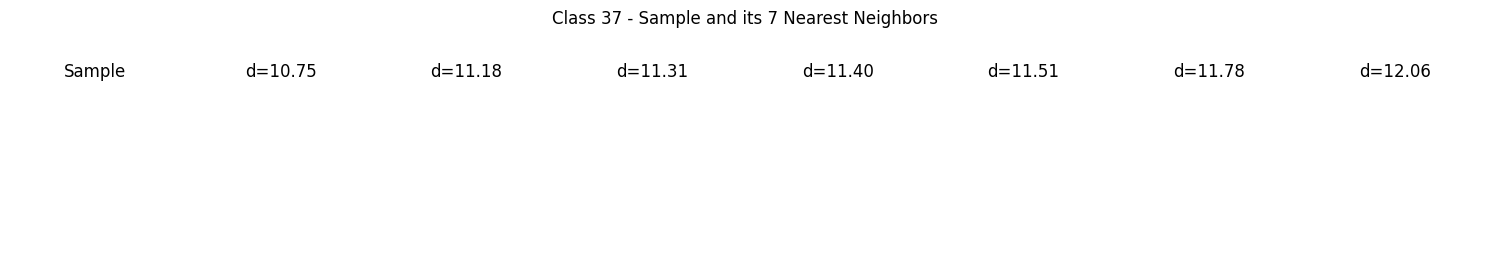

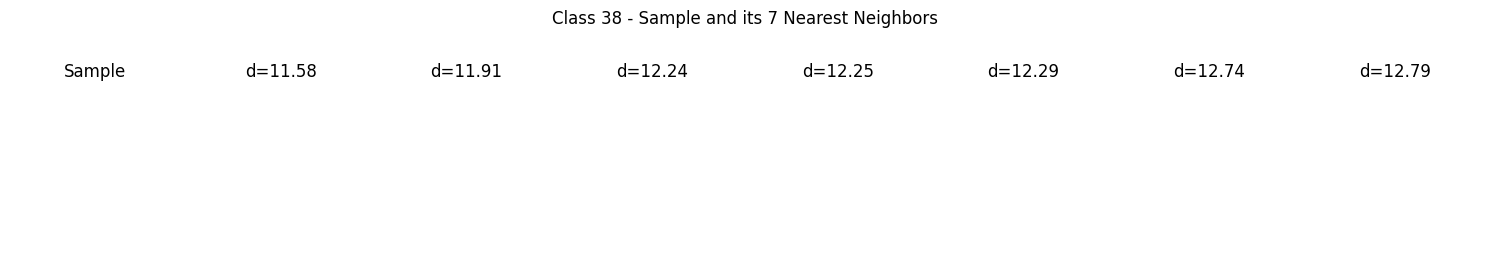

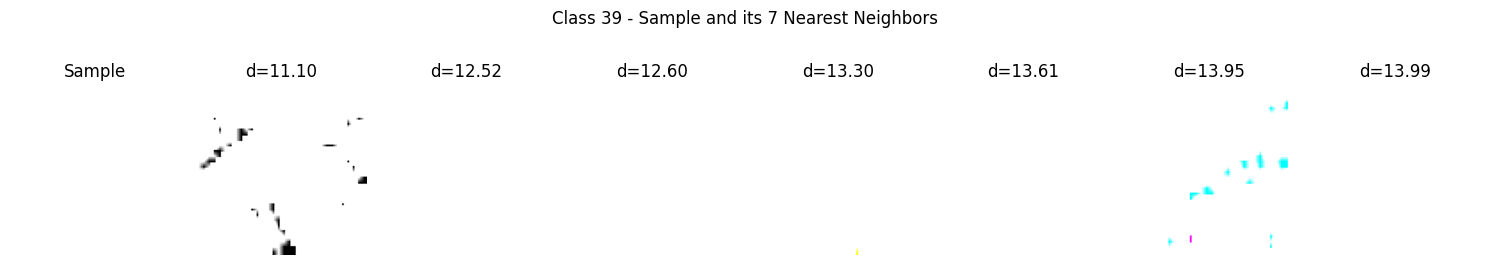

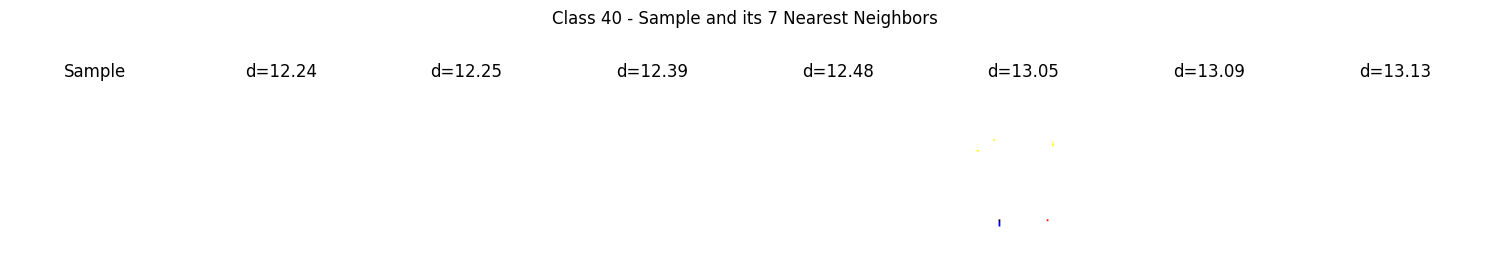

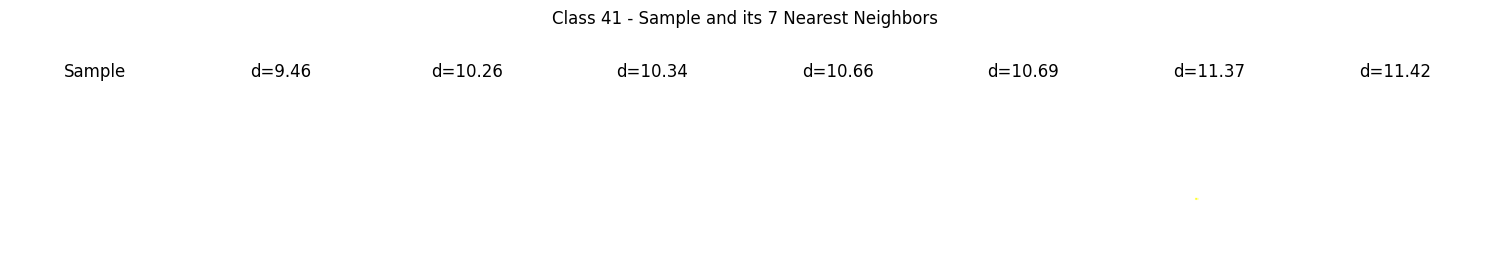

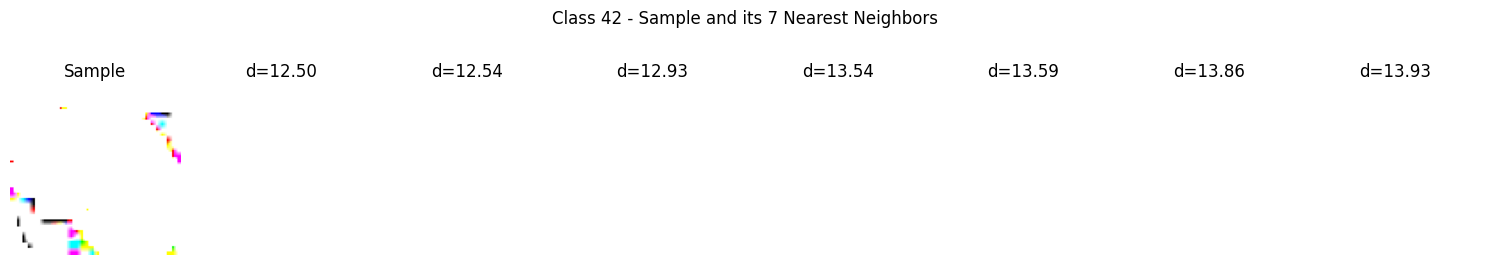

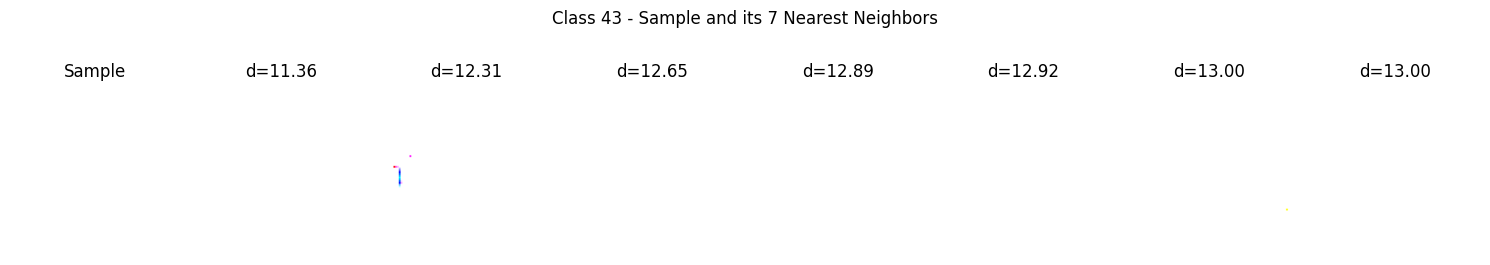

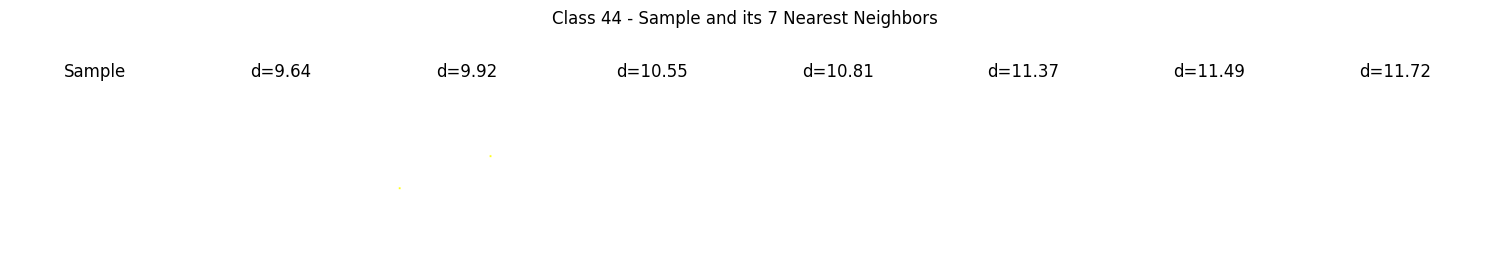

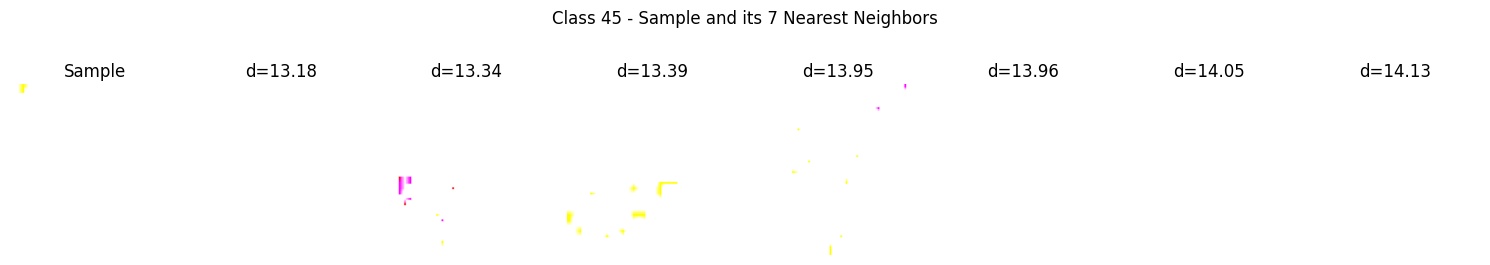

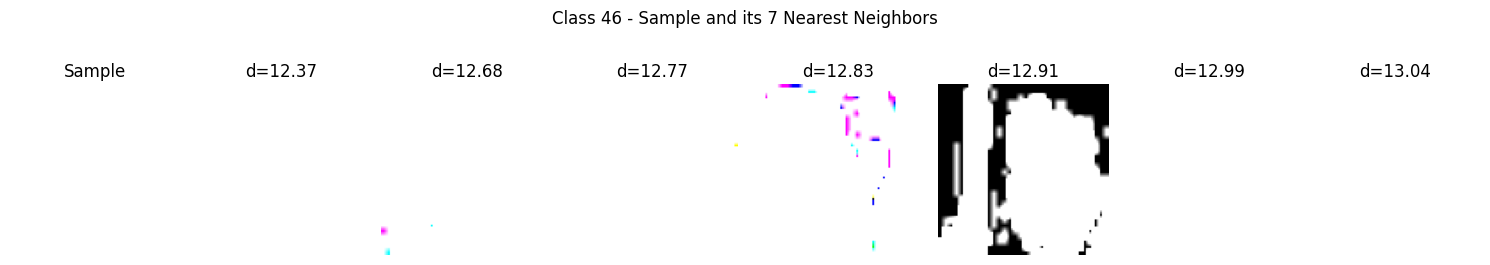

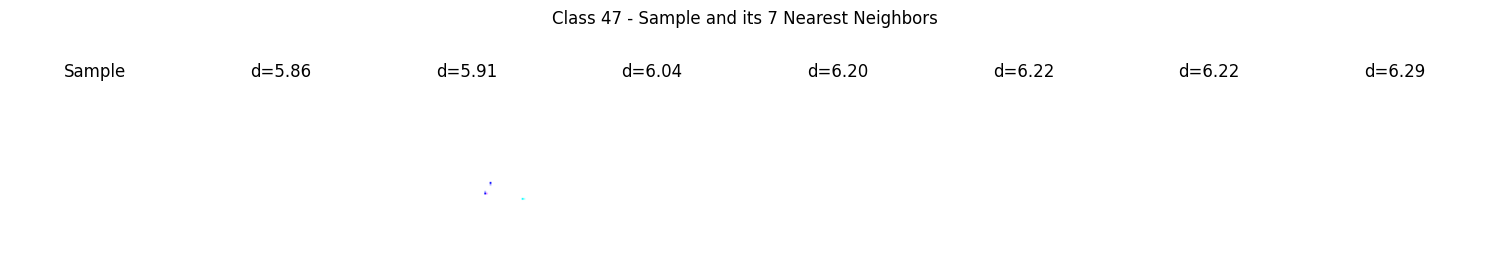

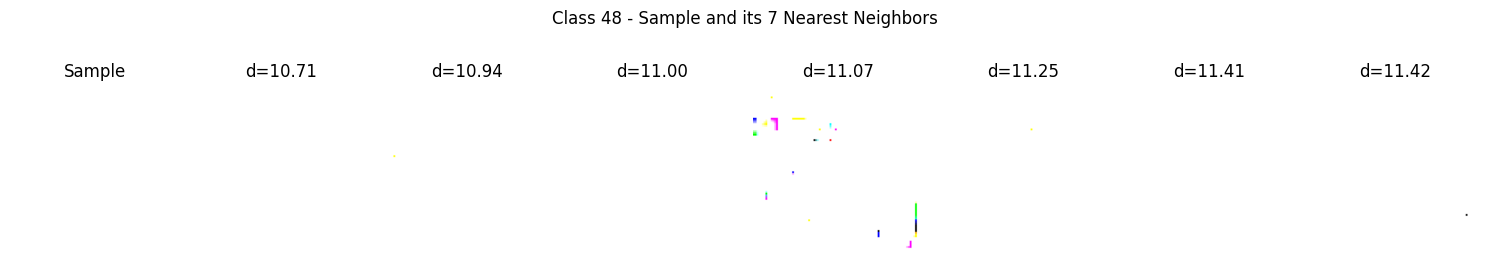

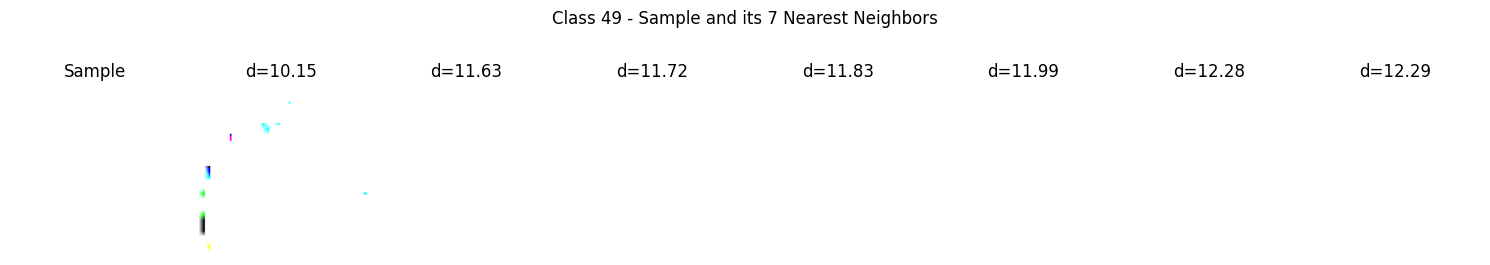

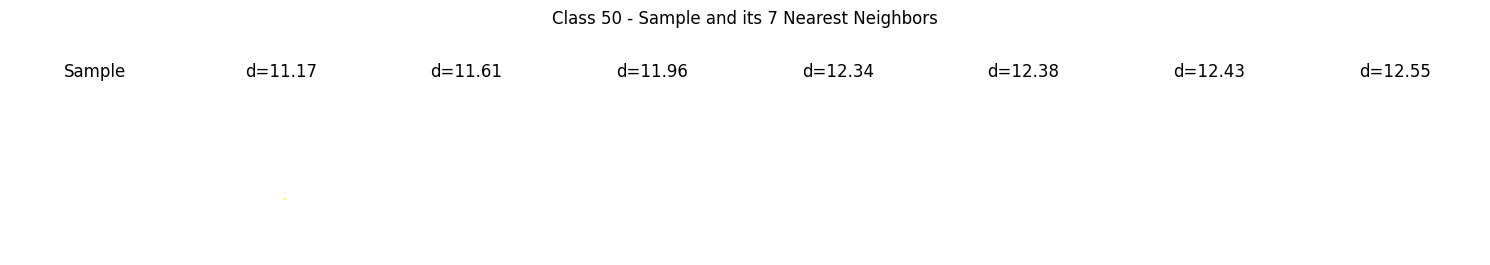

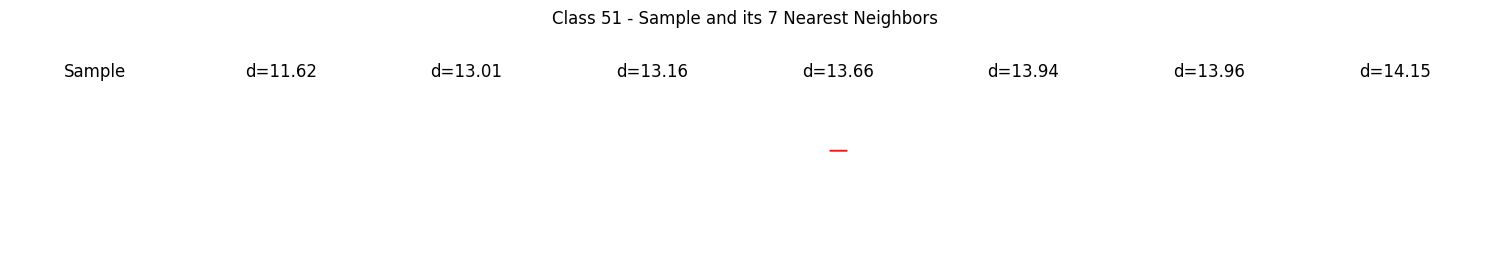

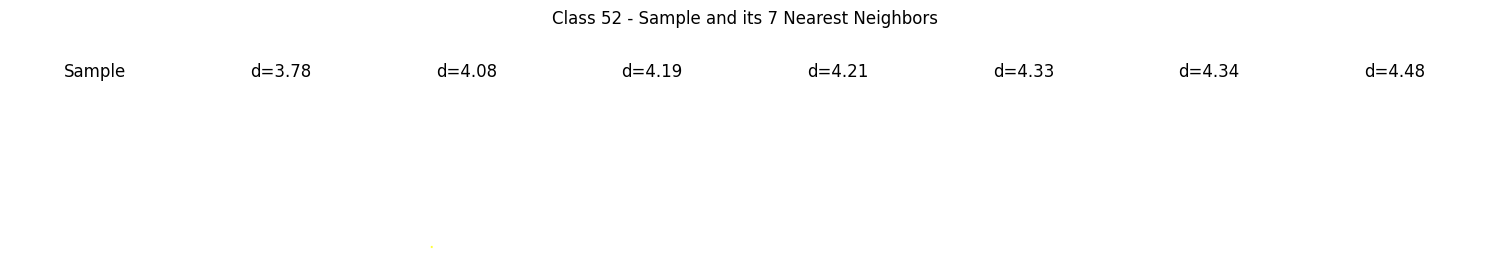

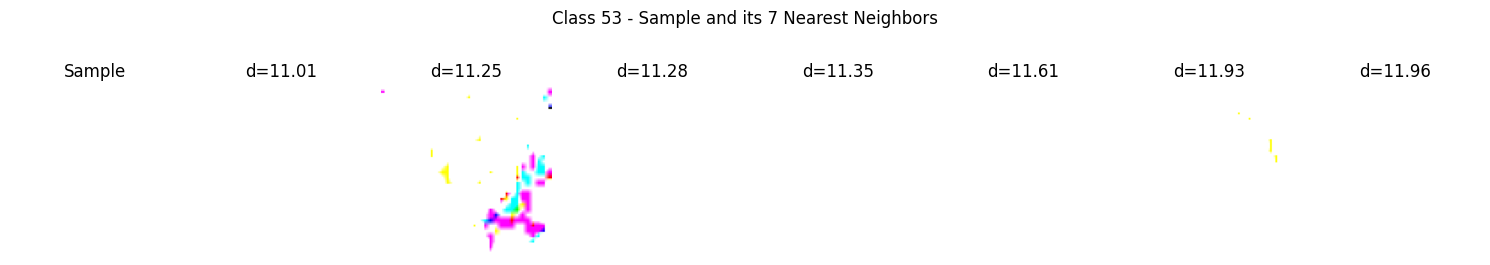

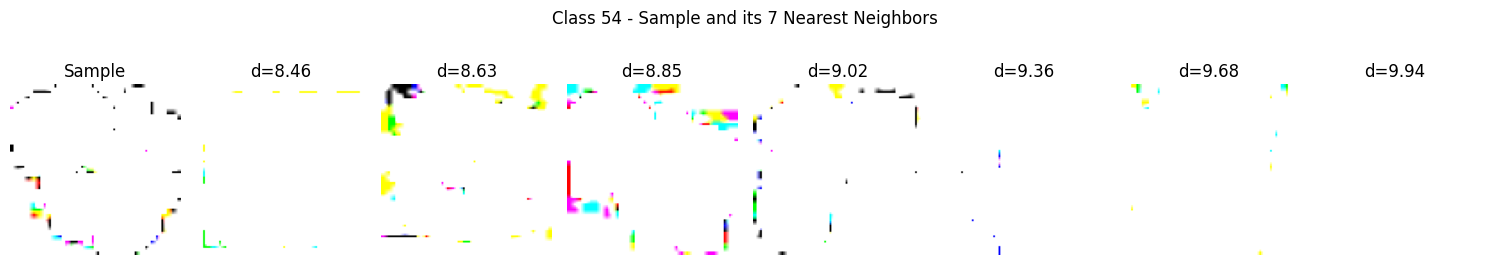

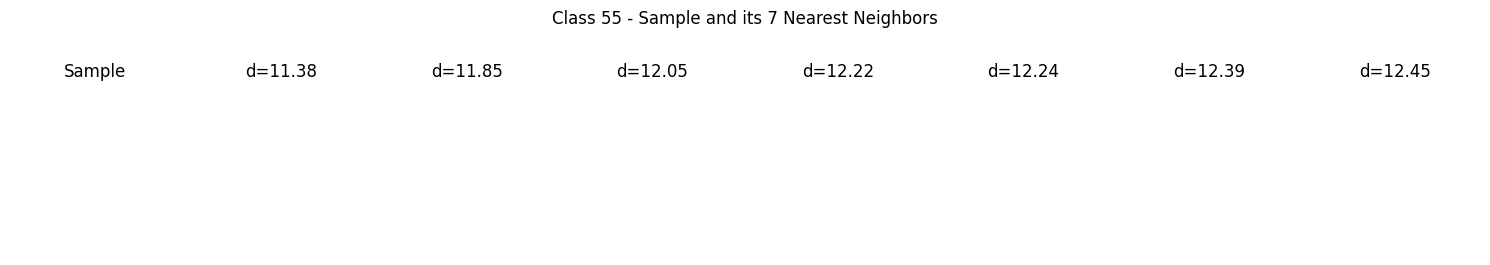

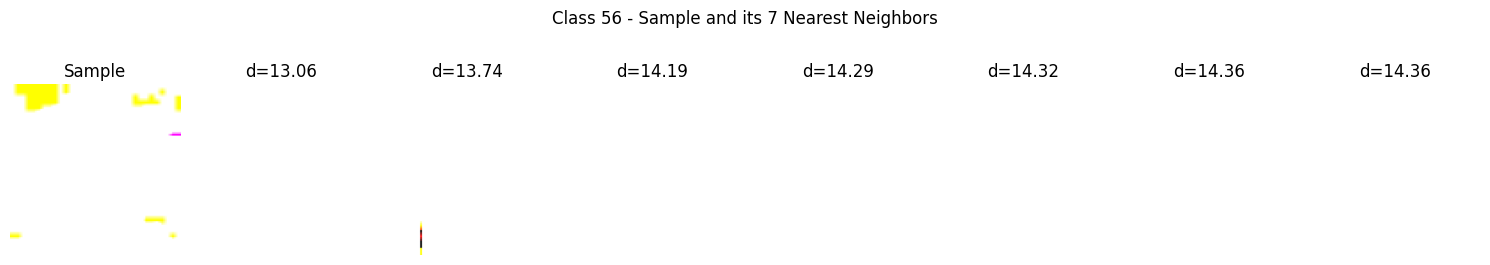

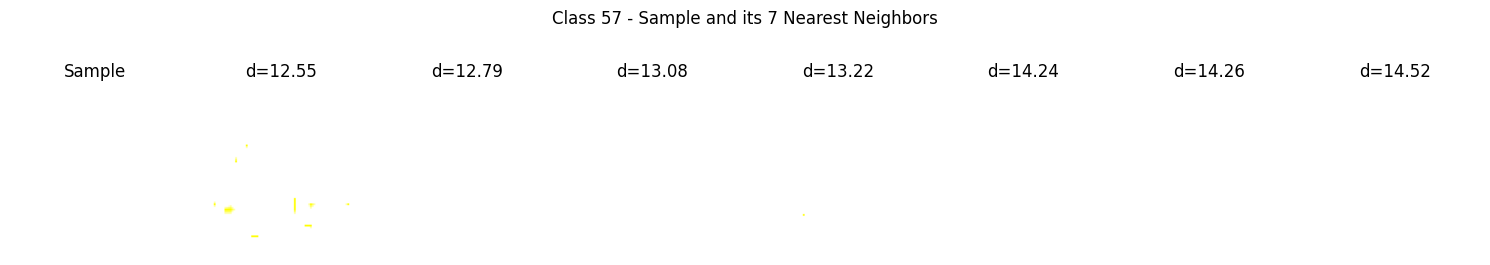

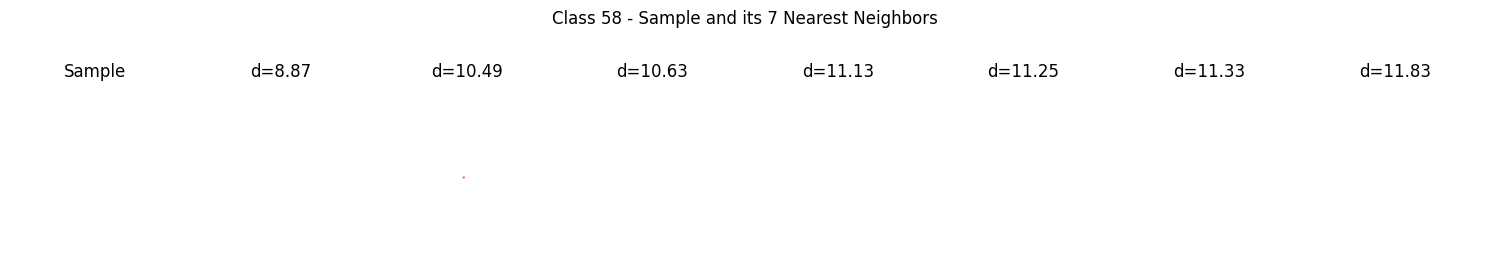

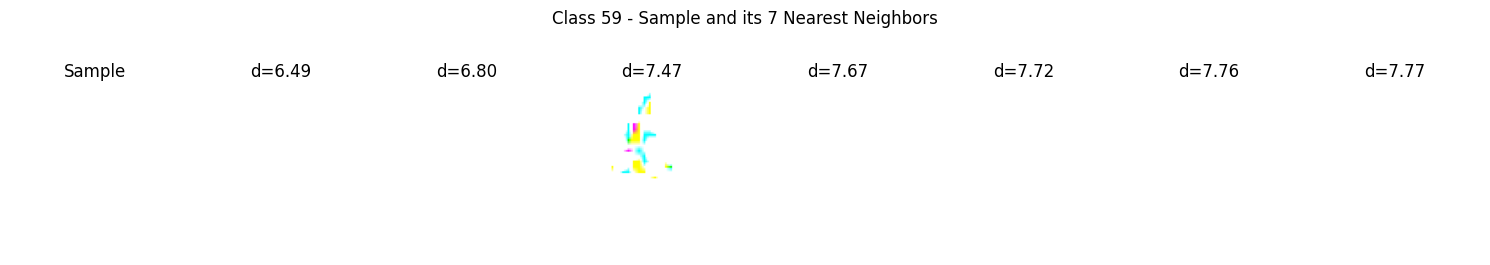

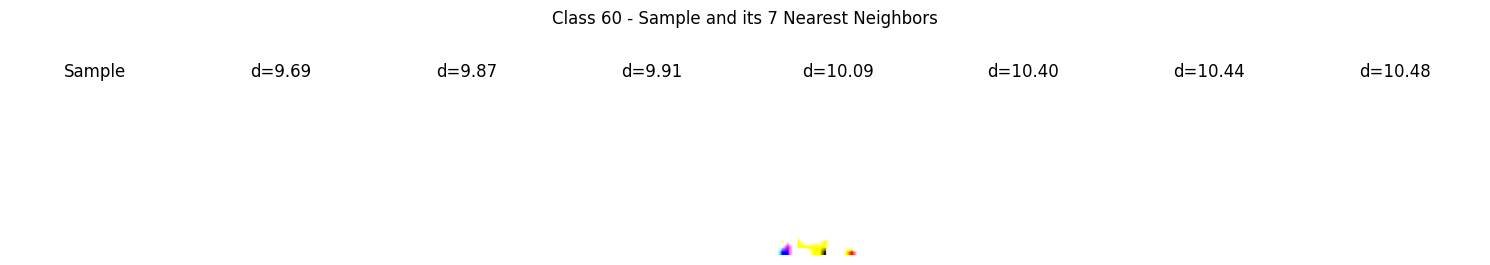

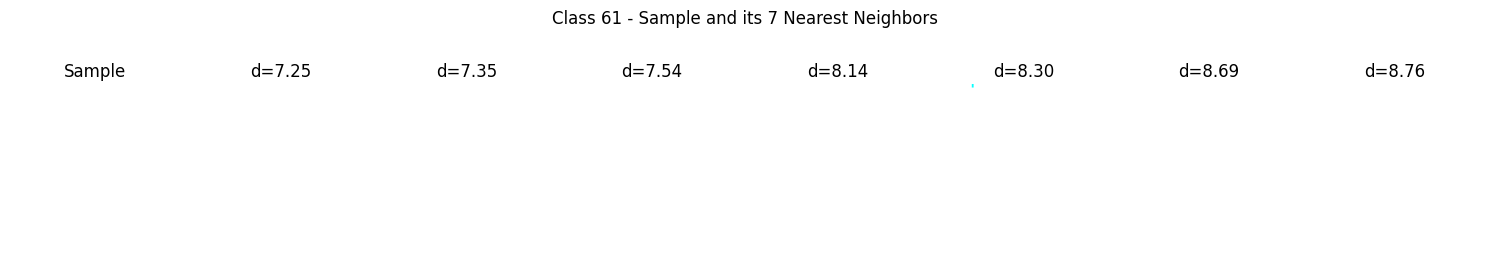

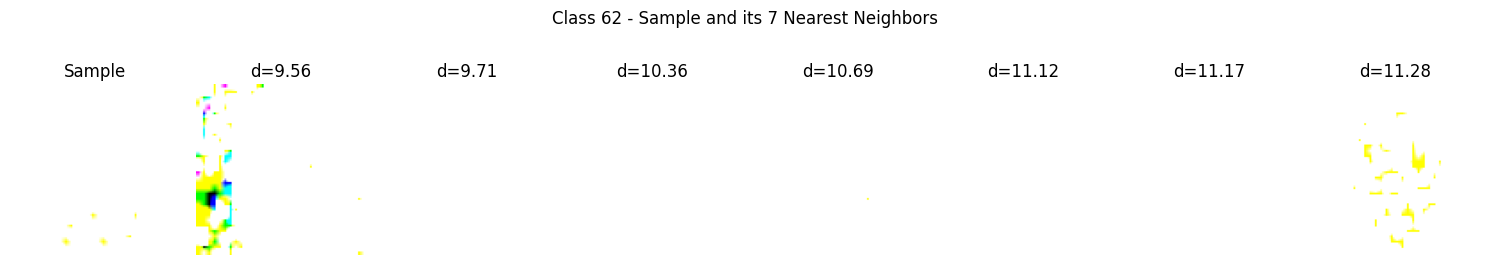

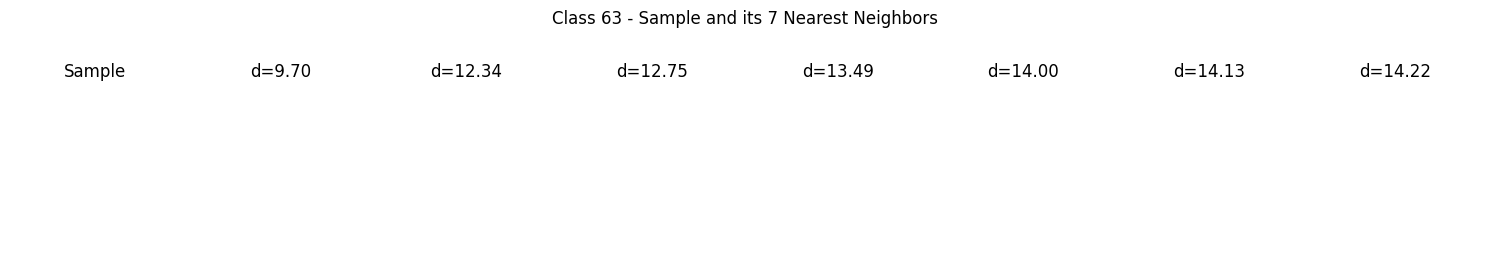

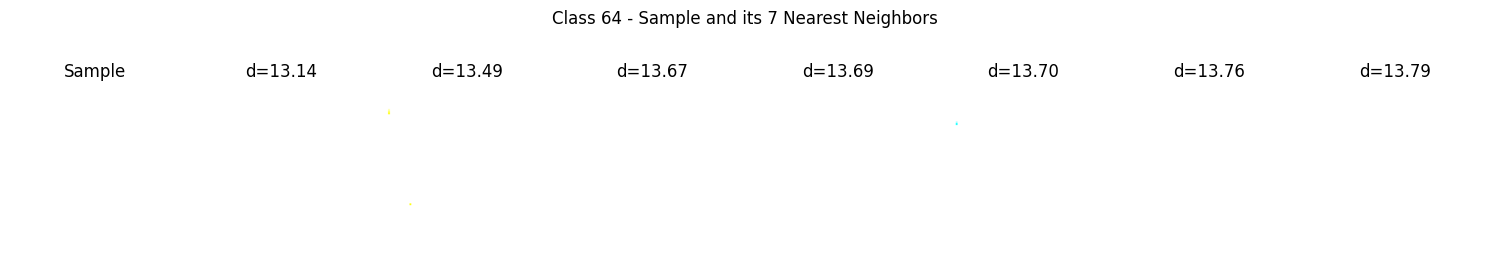

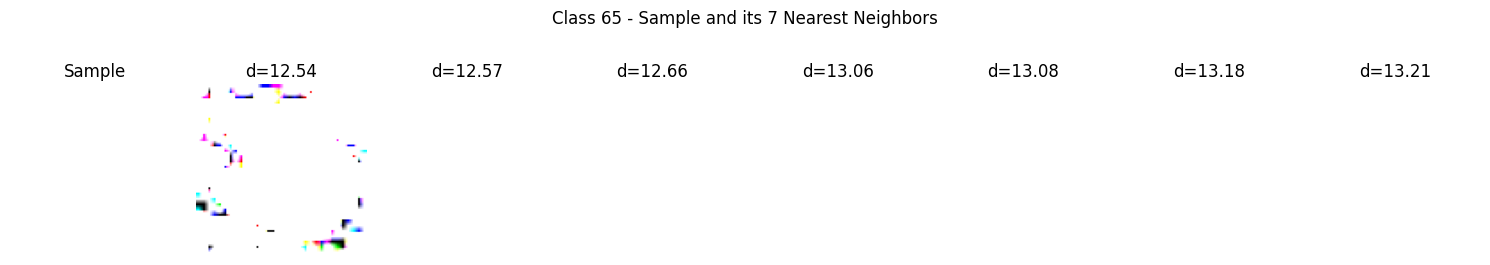

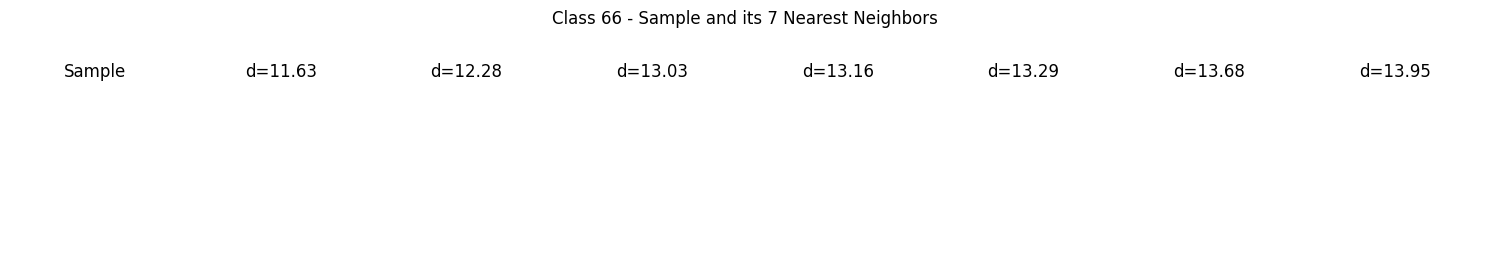

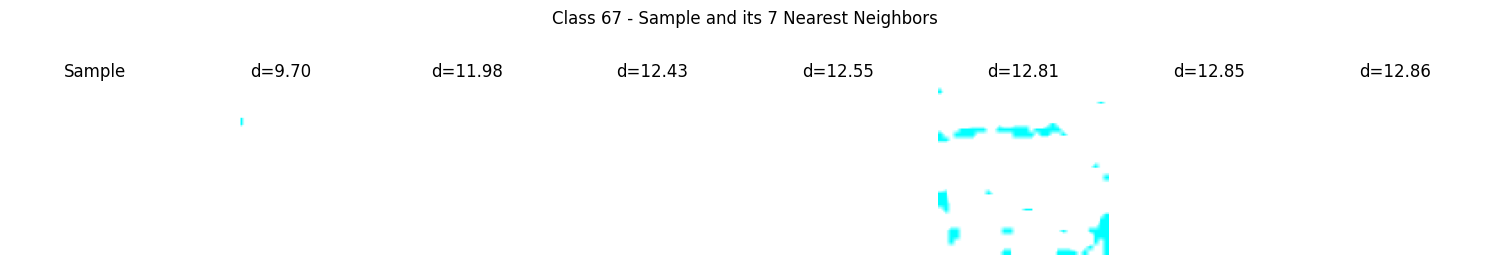

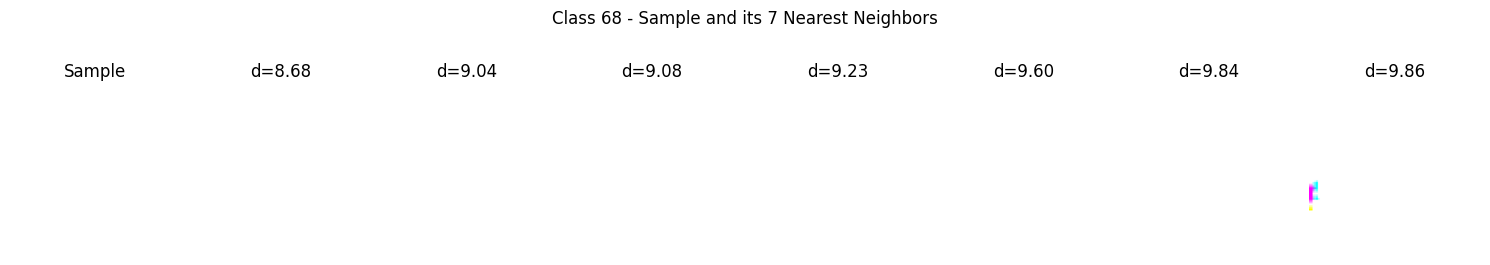

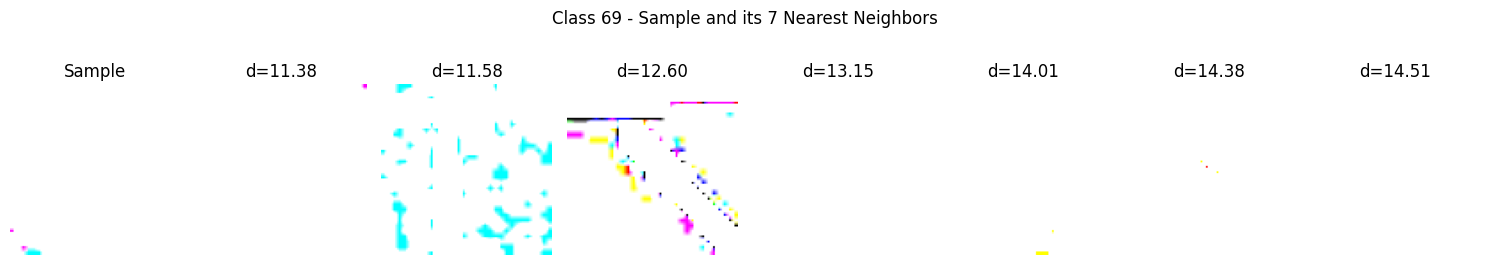

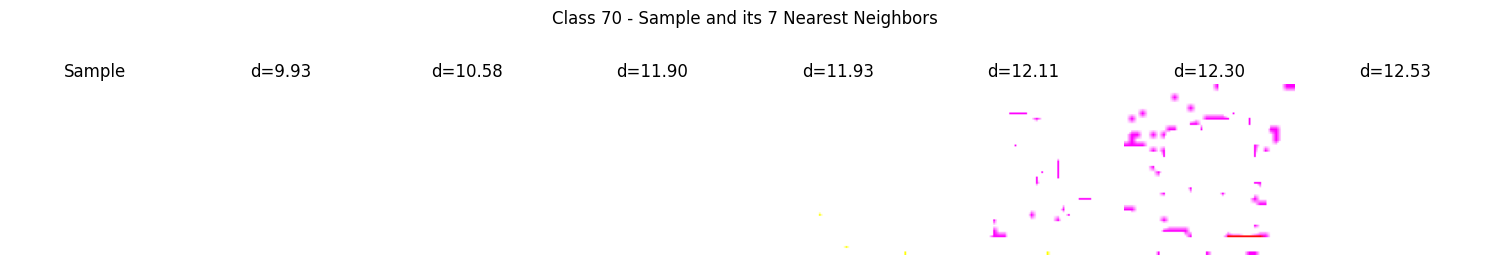

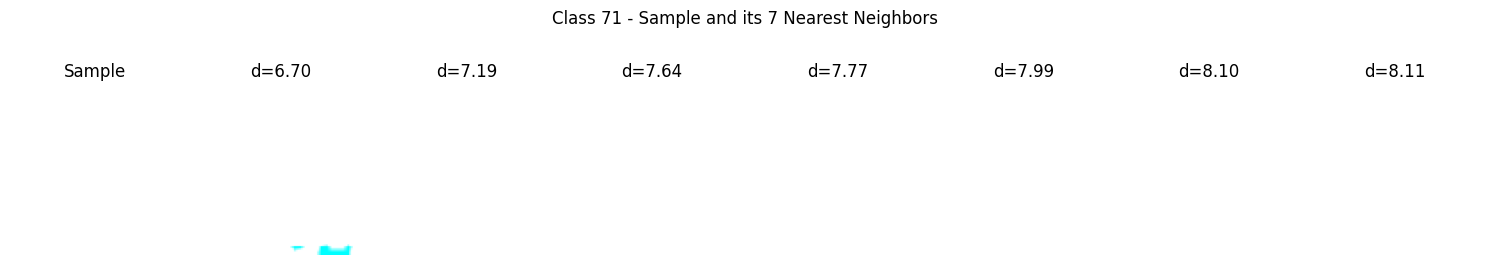

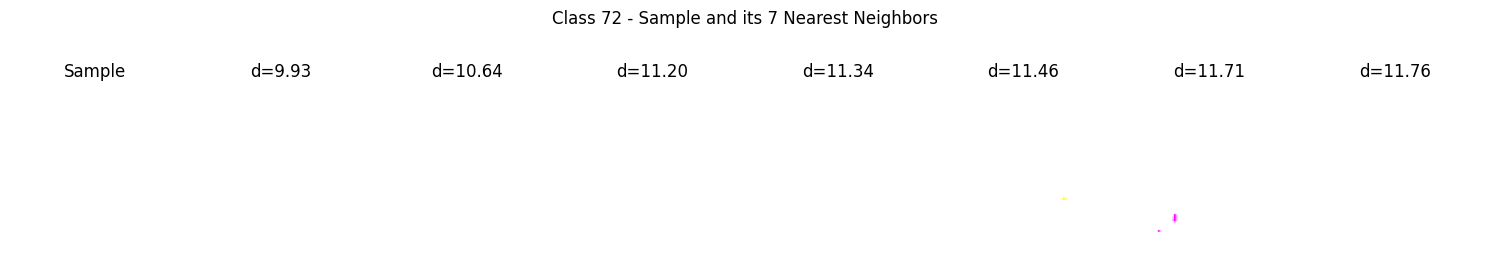

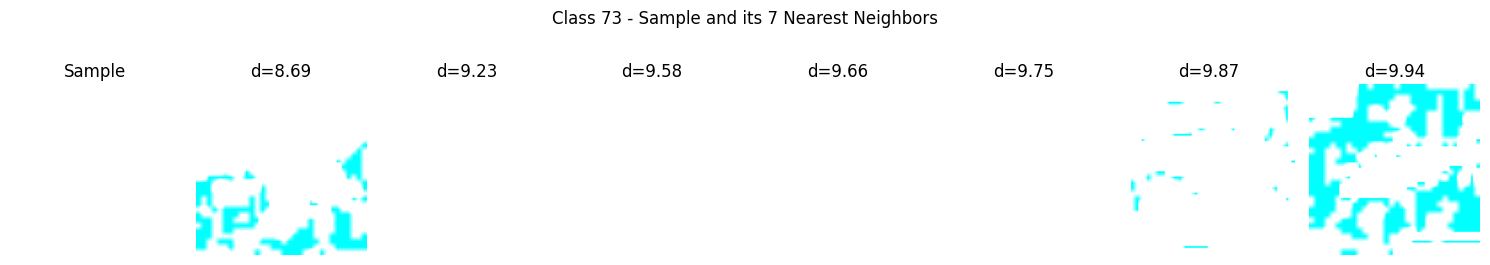

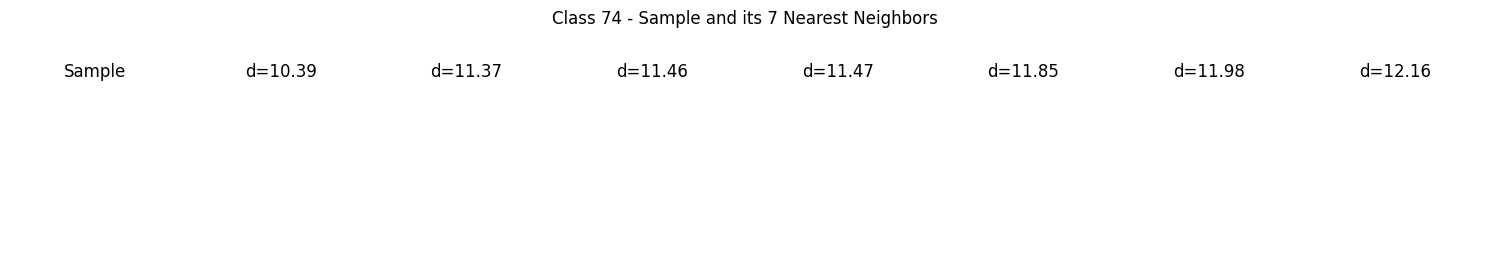

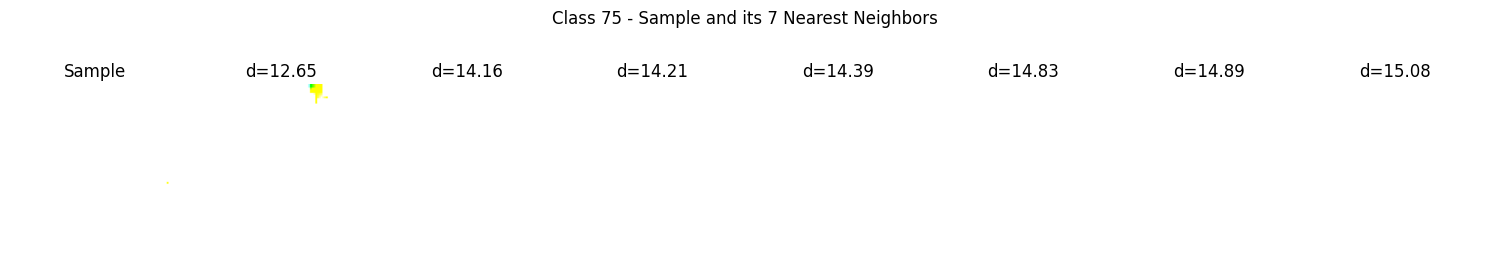

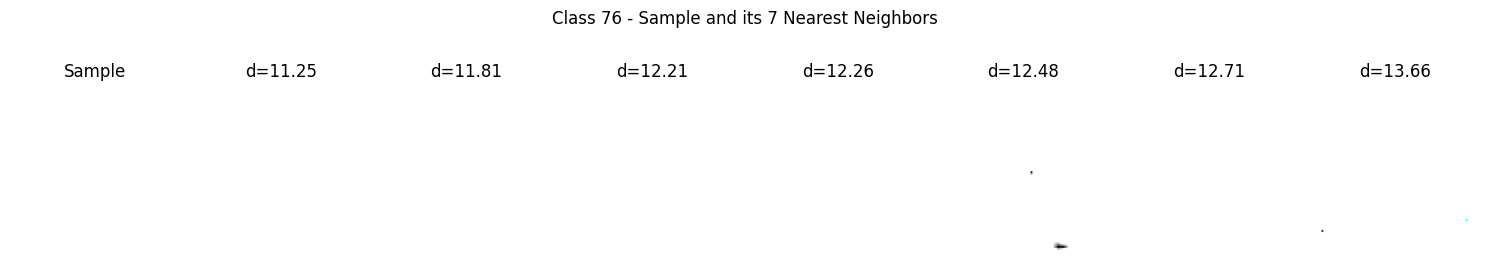

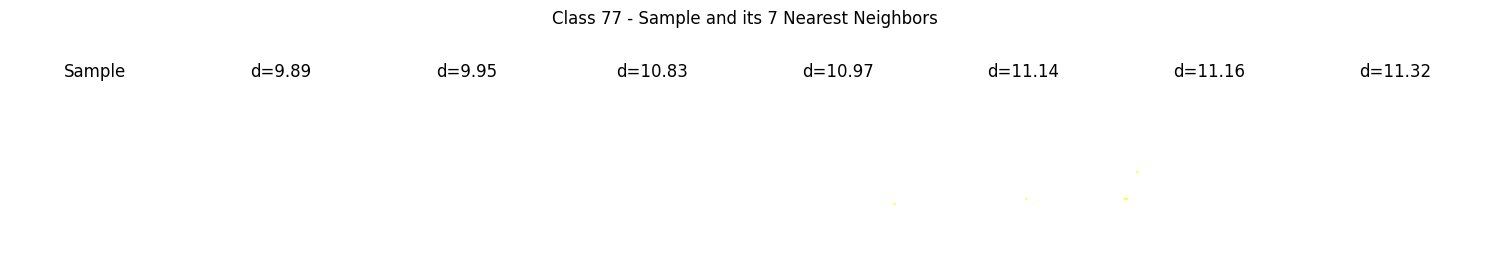

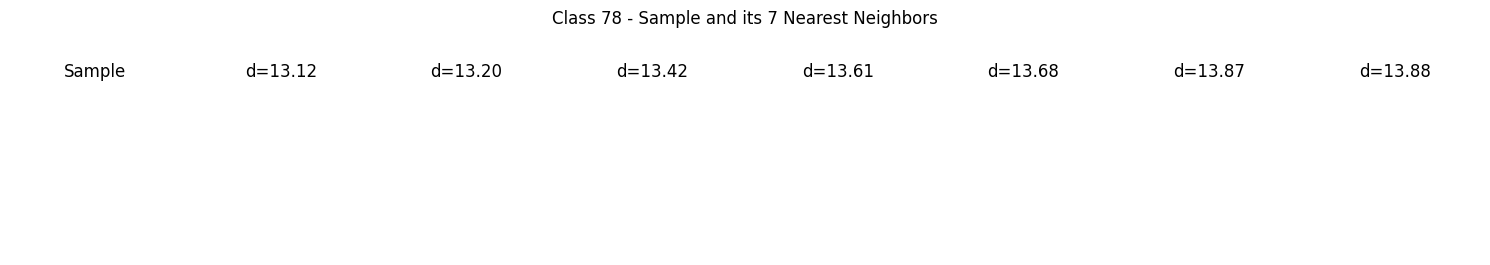

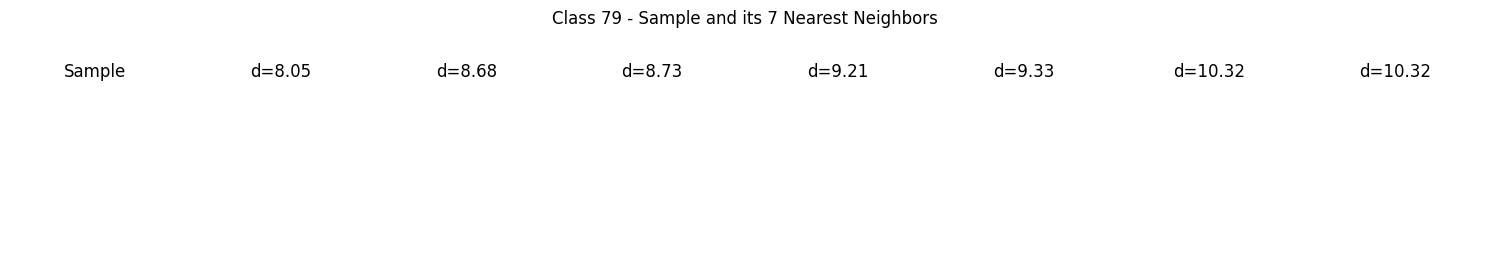

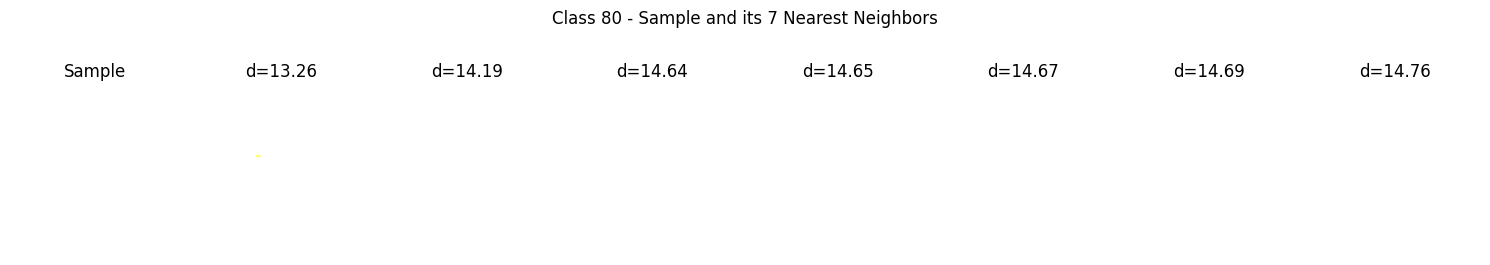

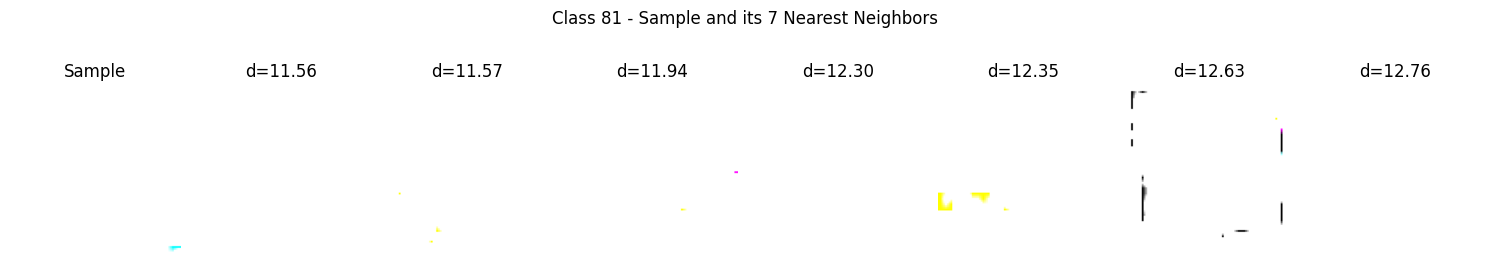

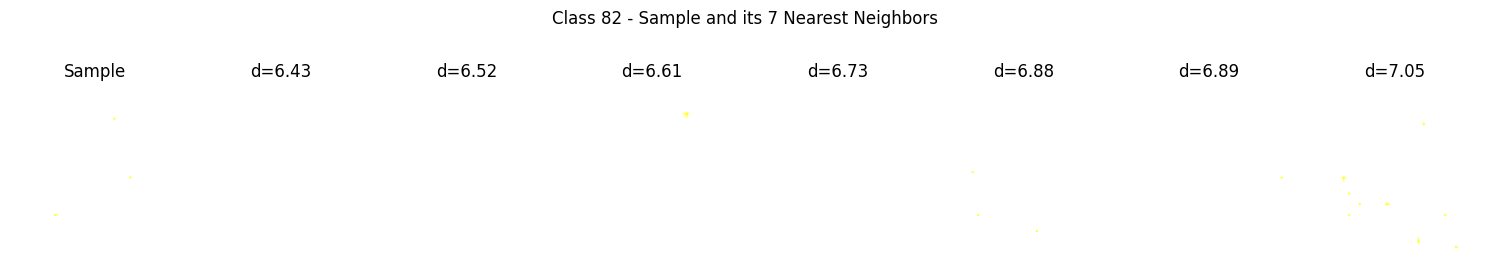

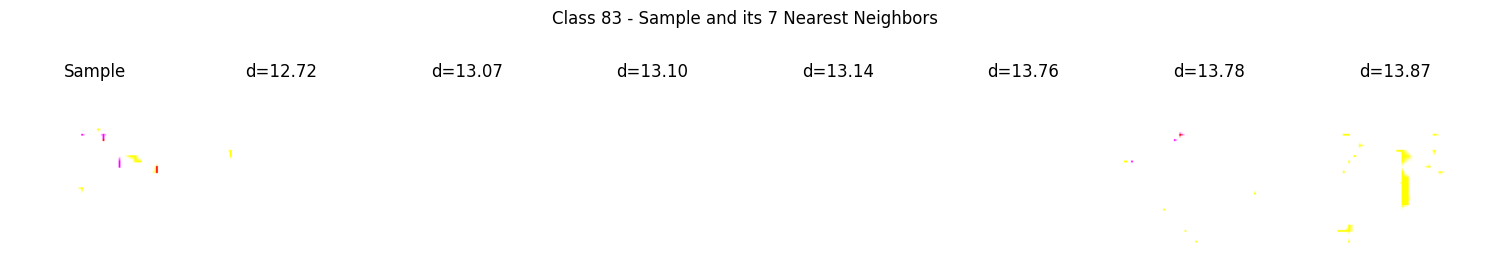

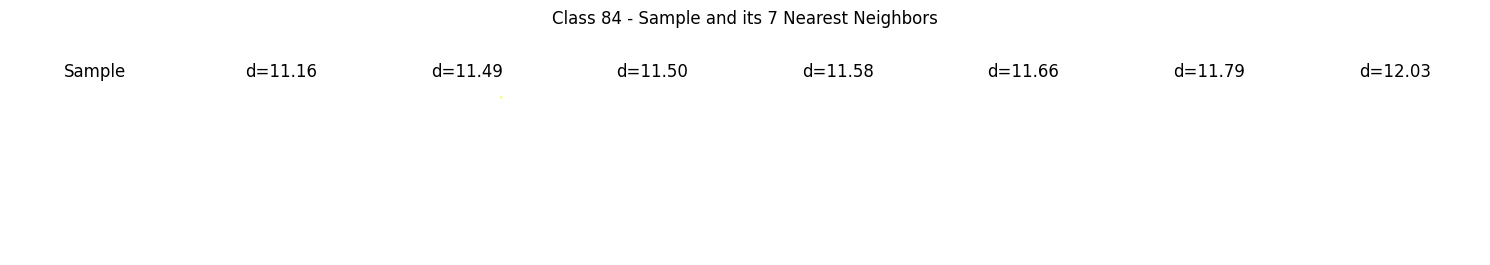

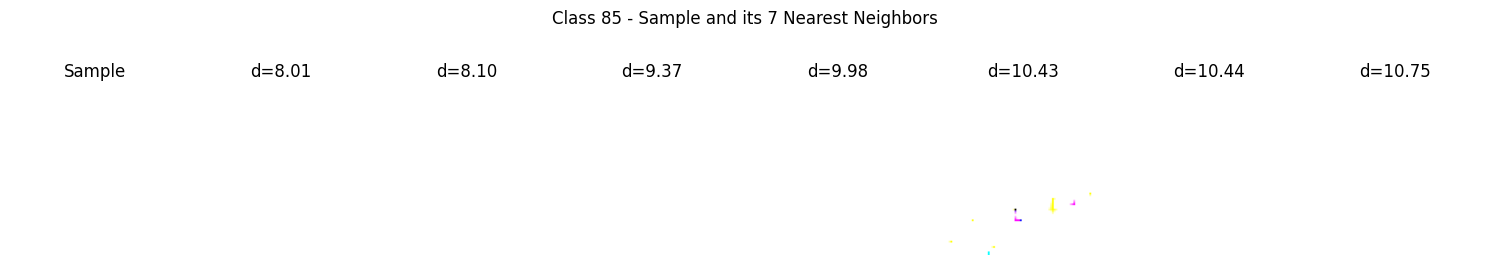

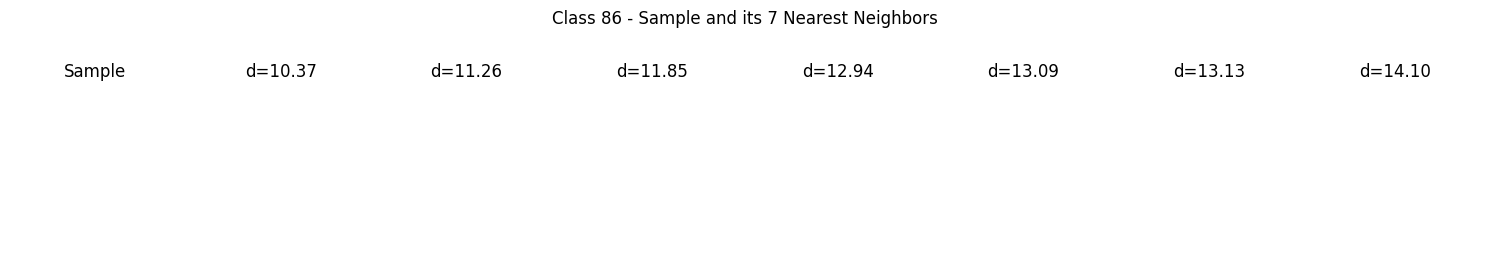

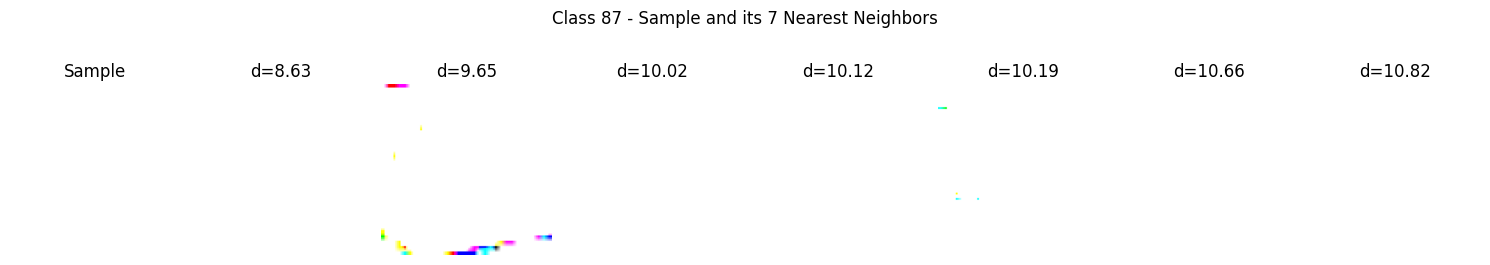

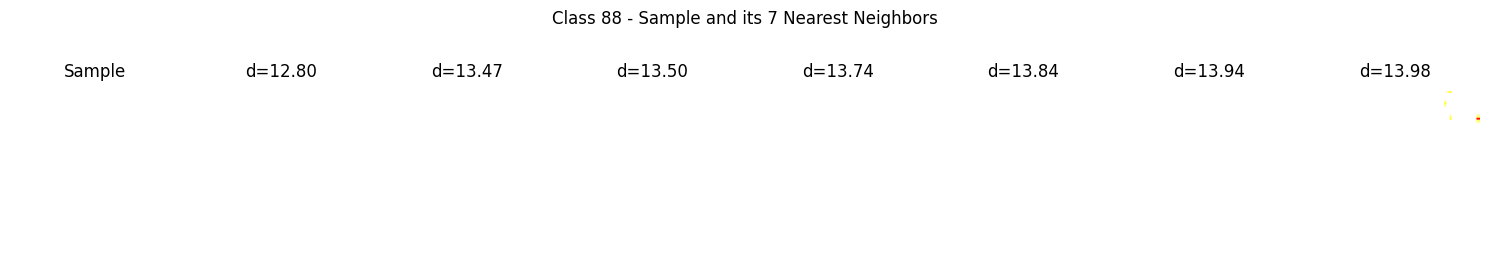

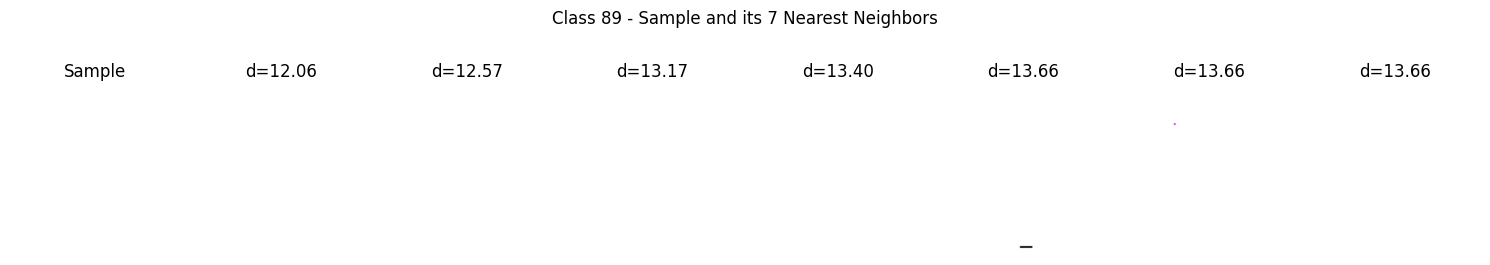

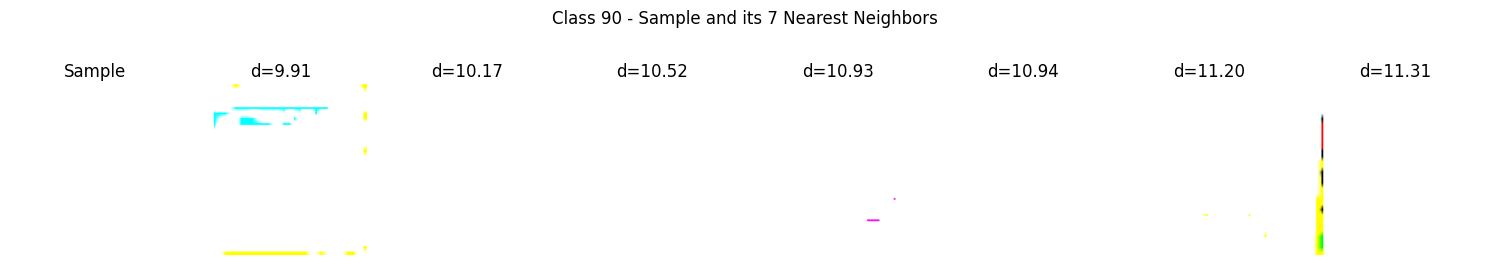

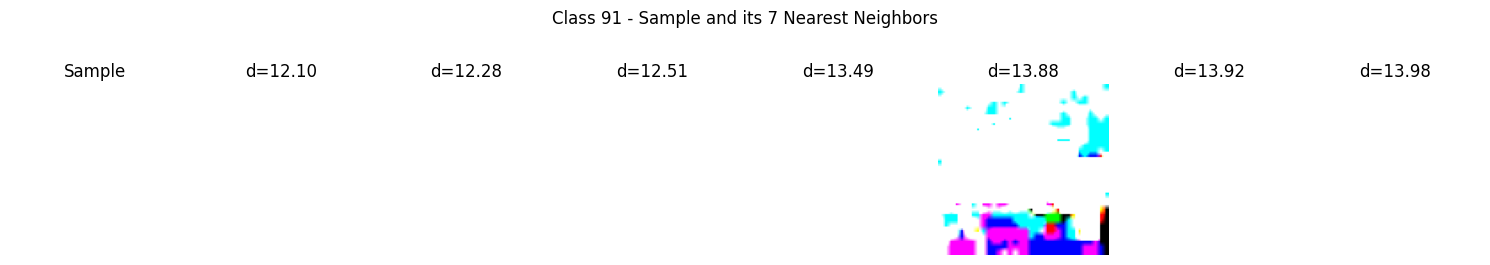

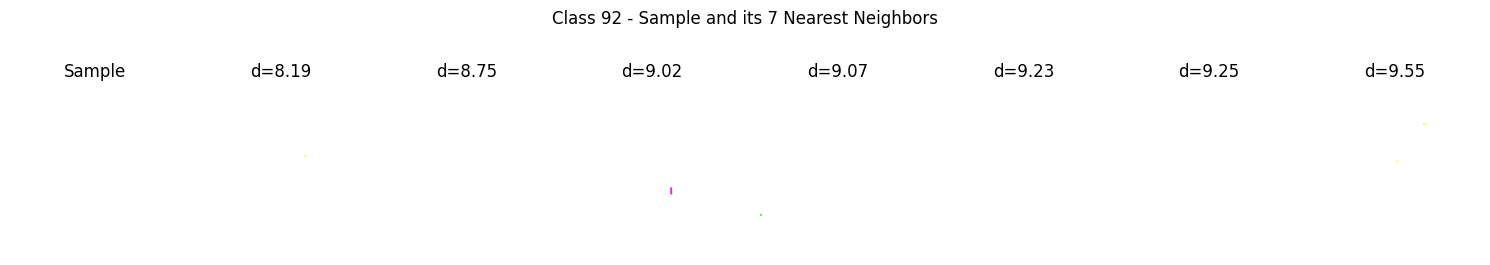

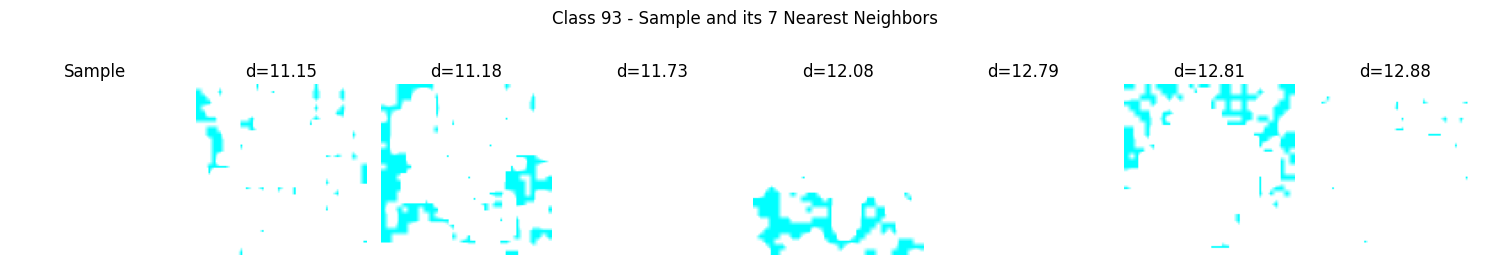

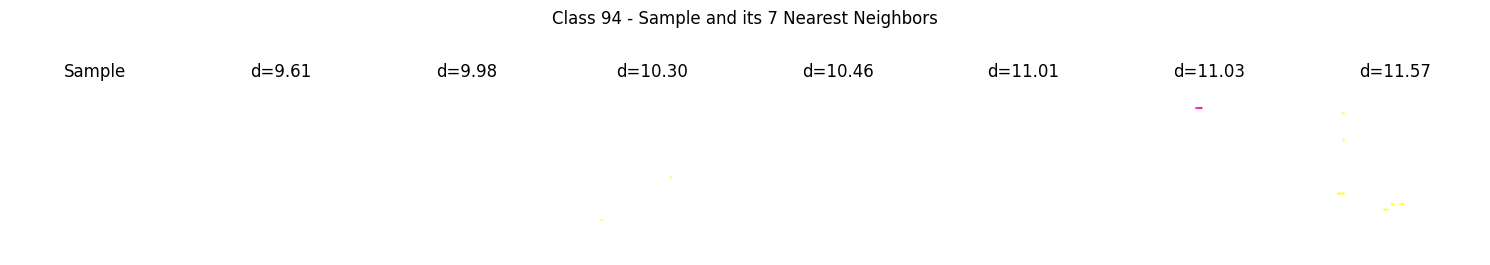

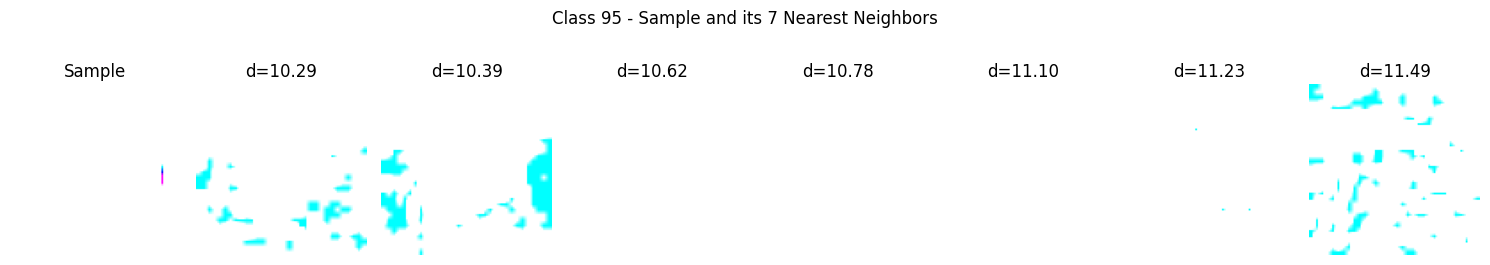

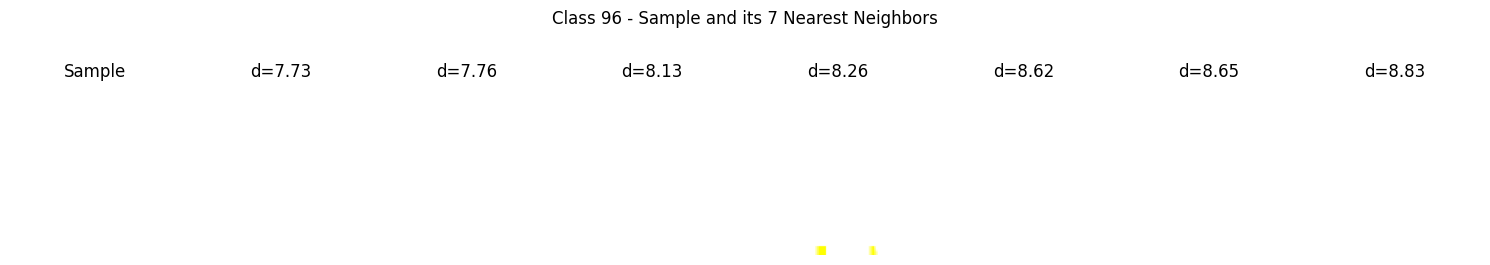

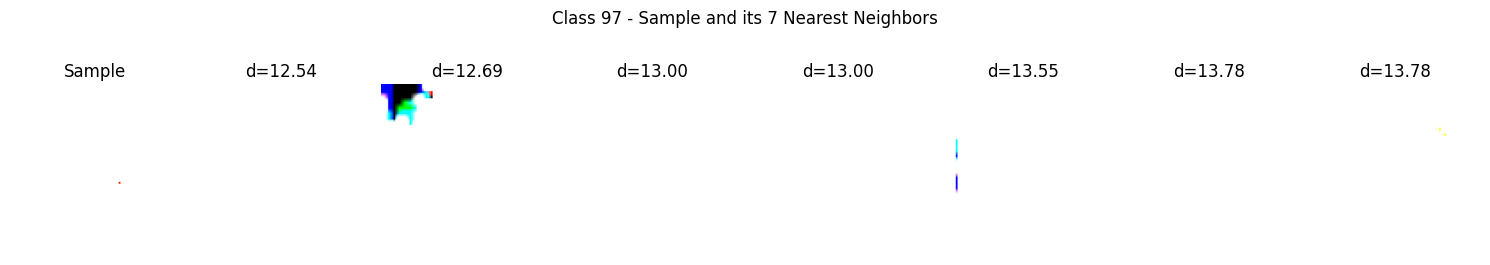

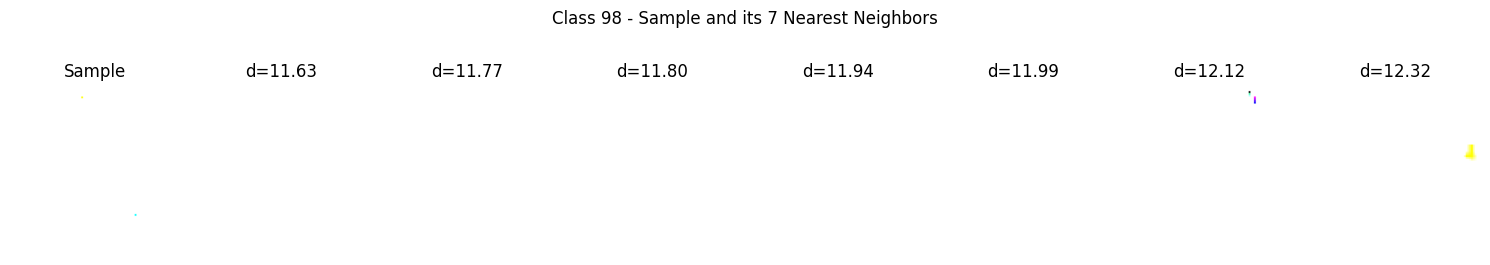

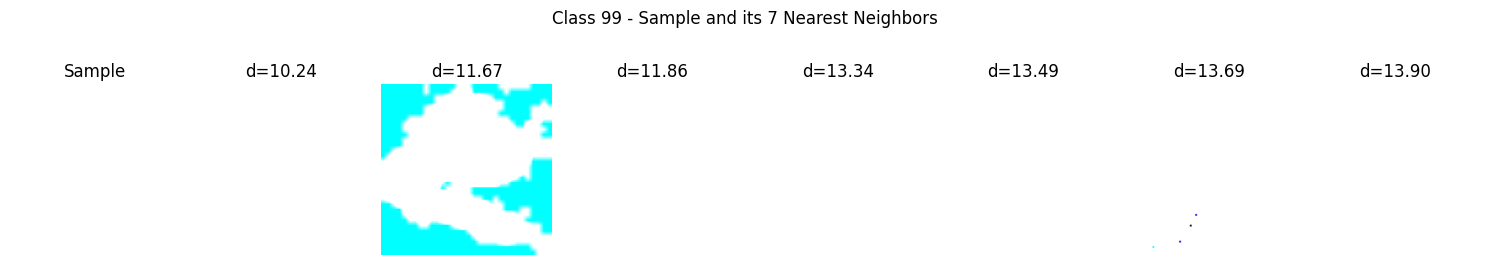

(<Functional name=functional_6, built=True>,
 {'predictions': array([[5.448e-05, 1.359e-05, 3.292e-03, ..., 3.755e-04, 6.500e-03,
          1.435e-04],
         [7.153e-07, 3.052e-05, 4.232e-06, ..., 2.890e-04, 2.128e-05,
          1.371e-06],
         [1.788e-07, 2.801e-06, 1.943e-05, ..., 2.533e-05, 8.059e-05,
          3.415e-05],
         ...,
         [2.384e-07, 5.960e-08, 0.000e+00, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.493e-05, 3.576e-06, 6.729e-05, ..., 9.460e-03, 8.446e-05,
          2.050e-05],
         [4.387e-05, 1.847e-04, 4.703e-05, ..., 1.788e-06, 4.828e-06,
          1.812e-05]], dtype=float16),
  'features': array([[-0.10767, -0.1395 , -0.1626 , ..., -0.2017 ,  0.078  ,  0.04236],
         [ 0.2327 , -0.01006,  0.5176 , ..., -0.10034, -0.0784 ,  1.092  ],
         [-0.1411 , -0.1704 ,  0.512  , ..., -0.1261 ,  1.129  ,  0.1459 ],
         ...,
         [-0.1295 ,  0.0775 , -0.07025, ...,  0.08307,  0.5947 ,  0.2966 ],
         [ 0.4468 , -0.128 

In [6]:
train_and_evaluate(dataset_name='cifar100', epochs=10, batch_size=32, target_size=(96, 96))